# 1. Data Understanding 

<font size="3"> The goal of this competition is to predict the age of abalone from physical measurements using various regression models.  The abalone's age is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope. We will be looking at numerous physical attributes to determine what the best predictors of age are. </font>

**PHYSICAL ATTRIBUTES**
1. **SEX:** <font size="3"> Male/Female/Infant</font>
2. **LENGTH:** <font size="3"> Longest shell measurement</font>
3. **DIAMETER:** <font size="3"> Diameter of the Abalone</font>
4. **HEIGHT:** <font size="3"> Height of the Abalone</font>
5. **WHOLE WEIGHT:** <font size="3"> Weight of the whole abalone</font>
6. **SHUCKED WEIGHT:** <font size="3"> Weight of the meat</font>
7. **VISCERA WEIGHT:** <font size="3"> Gut Weight - Interal Organs</font>
8. **SHELL WEIGHT:** <font size="3"> Shell Weight after drying</font>
9. **RINGS:** <font size="3"> Number of rings +1.5 gives Age of the Abalone</font>

**EVALUATION METRIC:** <font size="3"> The evaluation metric for this competition is Root Mean Squared Logarithmic Error. </font>

**ORIGINAL DATA:** The original data is sourced from the [site](https://archive.ics.uci.edu/dataset/1/abalone), however, data used in this analysis is from the kaggle website at [site] (https://www.kaggle.com/competitions/playground-series-s4e4/overview).

**SUBMISSION FILE:** For each id row in the test set, we must predict the target, Rings. The file should contain a header and have the following format:

id,Rings

90615,10

90616,10

90617,10

etc.

# 2. Import Packages 

In [1]:
%pip install pygam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 3.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import the needed Libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from mpl_toolkits import mplot3d
from sklearn.feature_selection import r_regression
import statsmodels.api as sm 
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro, jarque_bera
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from statsmodels.api import add_constant, OLS
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import OLSInfluence
from patsy import dmatrix
from pygam import LinearGAM, s, f
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.anova import anova_lm

import warnings
warnings.filterwarnings(
    "ignore",
    message=".*use_inf_as_na option is deprecated.*",
    category=FutureWarning
)
warnings.filterwarnings(
    "ignore",
    message=".*length-1 list-like.*get_group.*",
    category=FutureWarning
)

warnings.filterwarnings("ignore", category=RuntimeWarning)

# 3. Load Data 

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e4/sample_submission.csv
/kaggle/input/playground-series-s4e4/train.csv
/kaggle/input/playground-series-s4e4/test.csv


In [4]:

train= pd.read_csv('../input/playground-series-s4e4/train.csv')
test= pd.read_csv('../input/playground-series-s4e4/test.csv')

train_copy=train.copy()
test_copy=test.copy()

train=train.rename(columns={'Whole weight':'Whole_weight','Whole weight.1':'Shucked_weight', 'Whole weight.2':'Viscera_weight', 'Shell weight':'Shell_weight'})
test=test.rename(columns={'Whole weight':'Whole_weight','Whole weight.1':'Shucked_weight', 'Whole weight.2':'Viscera_weight', 'Shell weight':'Shell_weight'})

# Drop ID from training dataset 
train = train.drop('id', axis=1)

# change data types 
predict_col = ['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']
train[predict_col] = train[predict_col].astype('float64')

target = ['Rings']
train[target] = train[target].astype('int64')

test[predict_col] = test[predict_col].astype('float64')



In [5]:
train.head()

Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  Viscera_weight  \
0   F   0.550     0.430   0.150        0.7715          0.3285          0.1465   
1   F   0.630     0.490   0.145        1.1300          0.4580          0.2765   
2   I   0.160     0.110   0.025        0.0210          0.0055          0.0030   
3   M   0.595     0.475   0.150        0.9145          0.3755          0.2055   
4   I   0.555     0.425   0.130        0.7820          0.3695          0.1600   

   Shell_weight  Rings  
0        0.2400     11  
1        0.3200     11  
2        0.0050      6  
3        0.2500     10  
4        0.1975      9

In [6]:
test.head()

id Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  \
0  90615   M   0.645     0.475   0.155        1.2380          0.6185   
1  90616   M   0.580     0.460   0.160        0.9830          0.4785   
2  90617   M   0.560     0.420   0.140        0.8395          0.3525   
3  90618   M   0.570     0.490   0.145        0.8740          0.3525   
4  90619   I   0.415     0.325   0.110        0.3580          0.1575   

   Viscera_weight  Shell_weight  
0          0.3125        0.3005  
1          0.2195        0.2750  
2          0.1845        0.2405  
3          0.1865        0.2350  
4          0.0670        0.1050

# 4. Check for Missing and NaN Values 

In [7]:
# Check the info for the Train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             90615 non-null  object 
 1   Length          90615 non-null  float64
 2   Diameter        90615 non-null  float64
 3   Height          90615 non-null  float64
 4   Whole_weight    90615 non-null  float64
 5   Shucked_weight  90615 non-null  float64
 6   Viscera_weight  90615 non-null  float64
 7   Shell_weight    90615 non-null  float64
 8   Rings           90615 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 6.2+ MB


In [8]:
# Check the info for the Test dataset
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60411 entries, 0 to 60410
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              60411 non-null  int64  
 1   Sex             60411 non-null  object 
 2   Length          60411 non-null  float64
 3   Diameter        60411 non-null  float64
 4   Height          60411 non-null  float64
 5   Whole_weight    60411 non-null  float64
 6   Shucked_weight  60411 non-null  float64
 7   Viscera_weight  60411 non-null  float64
 8   Shell_weight    60411 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 4.1+ MB


In [9]:
# Check the shape of the Train dataset 
print("Train Shape:")
print(train.shape)

# Check the shape of the Test dataset 
print("Test Shape:")
print(test.shape)

Train Shape:
(90615, 9)
Test Shape:
(60411, 9)


In [10]:
# Check for NaNs in Train
print("Train with NaNs:")
print(train.isna())

# Check if any NaN exists in Train
if train.isna().any().any():
    print("\nDataFrame contains at least one NaN.")

Train with NaNs:
         Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  \
0      False   False     False   False         False           False   
1      False   False     False   False         False           False   
2      False   False     False   False         False           False   
3      False   False     False   False         False           False   
4      False   False     False   False         False           False   
...      ...     ...       ...     ...           ...             ...   
90610  False   False     False   False         False           False   
90611  False   False     False   False         False           False   
90612  False   False     False   False         False           False   
90613  False   False     False   False         False           False   
90614  False   False     False   False         False           False   

       Viscera_weight  Shell_weight  Rings  
0               False         False  False  
1               False       

In [11]:
# Check for 0 or below 0 values Train
(train == 0).sum()

Sex               0
Length            0
Diameter          0
Height            6
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
Rings             0
dtype: int64

In [12]:
# Drop columns with a value of 0 
train = train[~(train == 0).any(axis=1)]

# Check the shape of the Train dataset 
print("Train Shape:")
print(train.shape)

Train Shape:
(90609, 9)


In [13]:
# Check for negative values 
(train[predict_col] < 0).sum()


Length            0
Diameter          0
Height            0
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
dtype: int64

# 5. Exploratory Data Analysis 

## 5.1 Look at training ring distributions

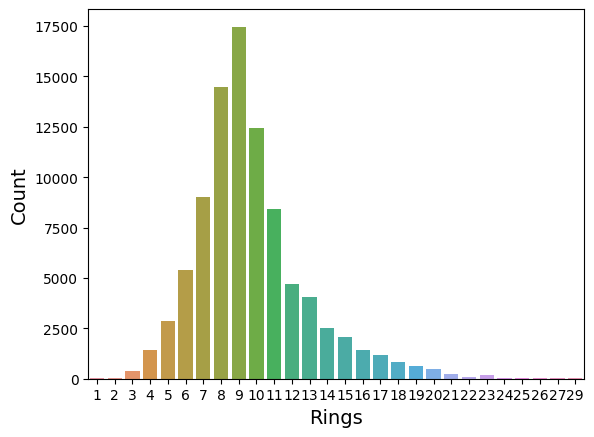

In [14]:
p = sns.countplot(data=train, x='Rings')
p.set_xlabel('Rings', fontsize=14)
p.set_ylabel('Count', fontsize=14)
plt.show()

## 5.2 Create a histogram to see distribution of data between train and test 

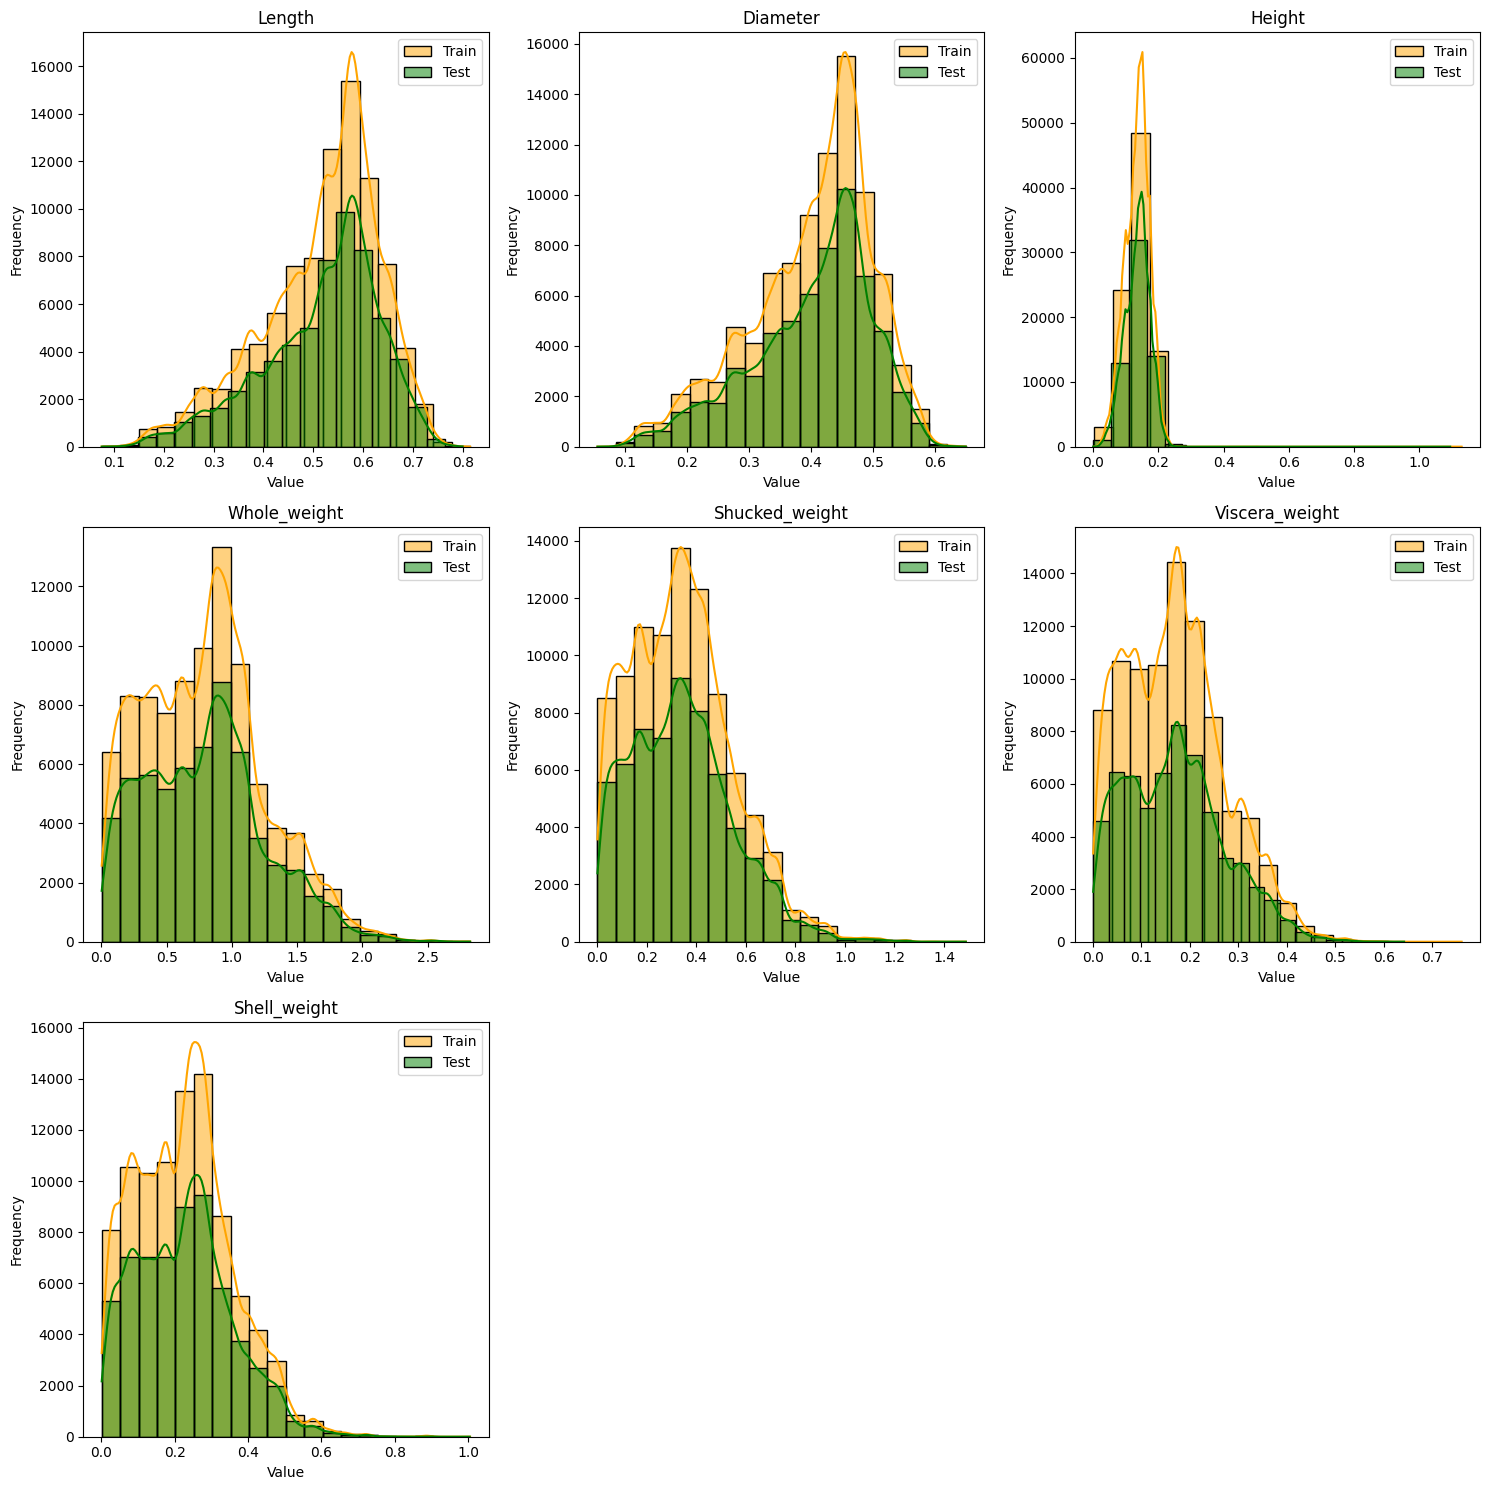

In [15]:
cont_cols = ['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']

# Calculate the number of rows needed for the subplots
num_rows = (len(cont_cols) + 2) // 3

# Create subplots for each continuous column
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows*5))

# Loop through each continuous column and plot the histograms
for i, col in enumerate(cont_cols):
    # Determine the range of values to plot
    max_val = max(train[col].max(), test[col].max())
    min_val = min(train[col].min(), test[col].min())
    range_val = max_val - min_val
    
    # Determine the bin size and number of bins
    bin_size = range_val / 20
    num_bins_train = round(range_val / bin_size)
    num_bins_test = round(range_val / bin_size)
    
    # Calculate the subplot position
    row = i // 3
    col_pos = i % 3
    
    # Plot the histograms
    sns.histplot(train[col], ax=axs[row][col_pos], color='orange', kde=True, label='Train', bins=num_bins_train)
    sns.histplot(test[col], ax=axs[row][col_pos], color='green', kde=True, label='Test', bins=num_bins_test)
    axs[row][col_pos].set_title(col)
    axs[row][col_pos].set_xlabel('Value')
    axs[row][col_pos].set_ylabel('Frequency')
    axs[row][col_pos].legend()

# Remove any empty subplots
if len(cont_cols) % 3 != 0:
    for col_pos in range(len(cont_cols) % 3, 3):
        axs[-1][col_pos].remove()

plt.tight_layout()
plt.show()

## 5.3 Plot the target value by sex against numerical variables 

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_13/2969818231.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


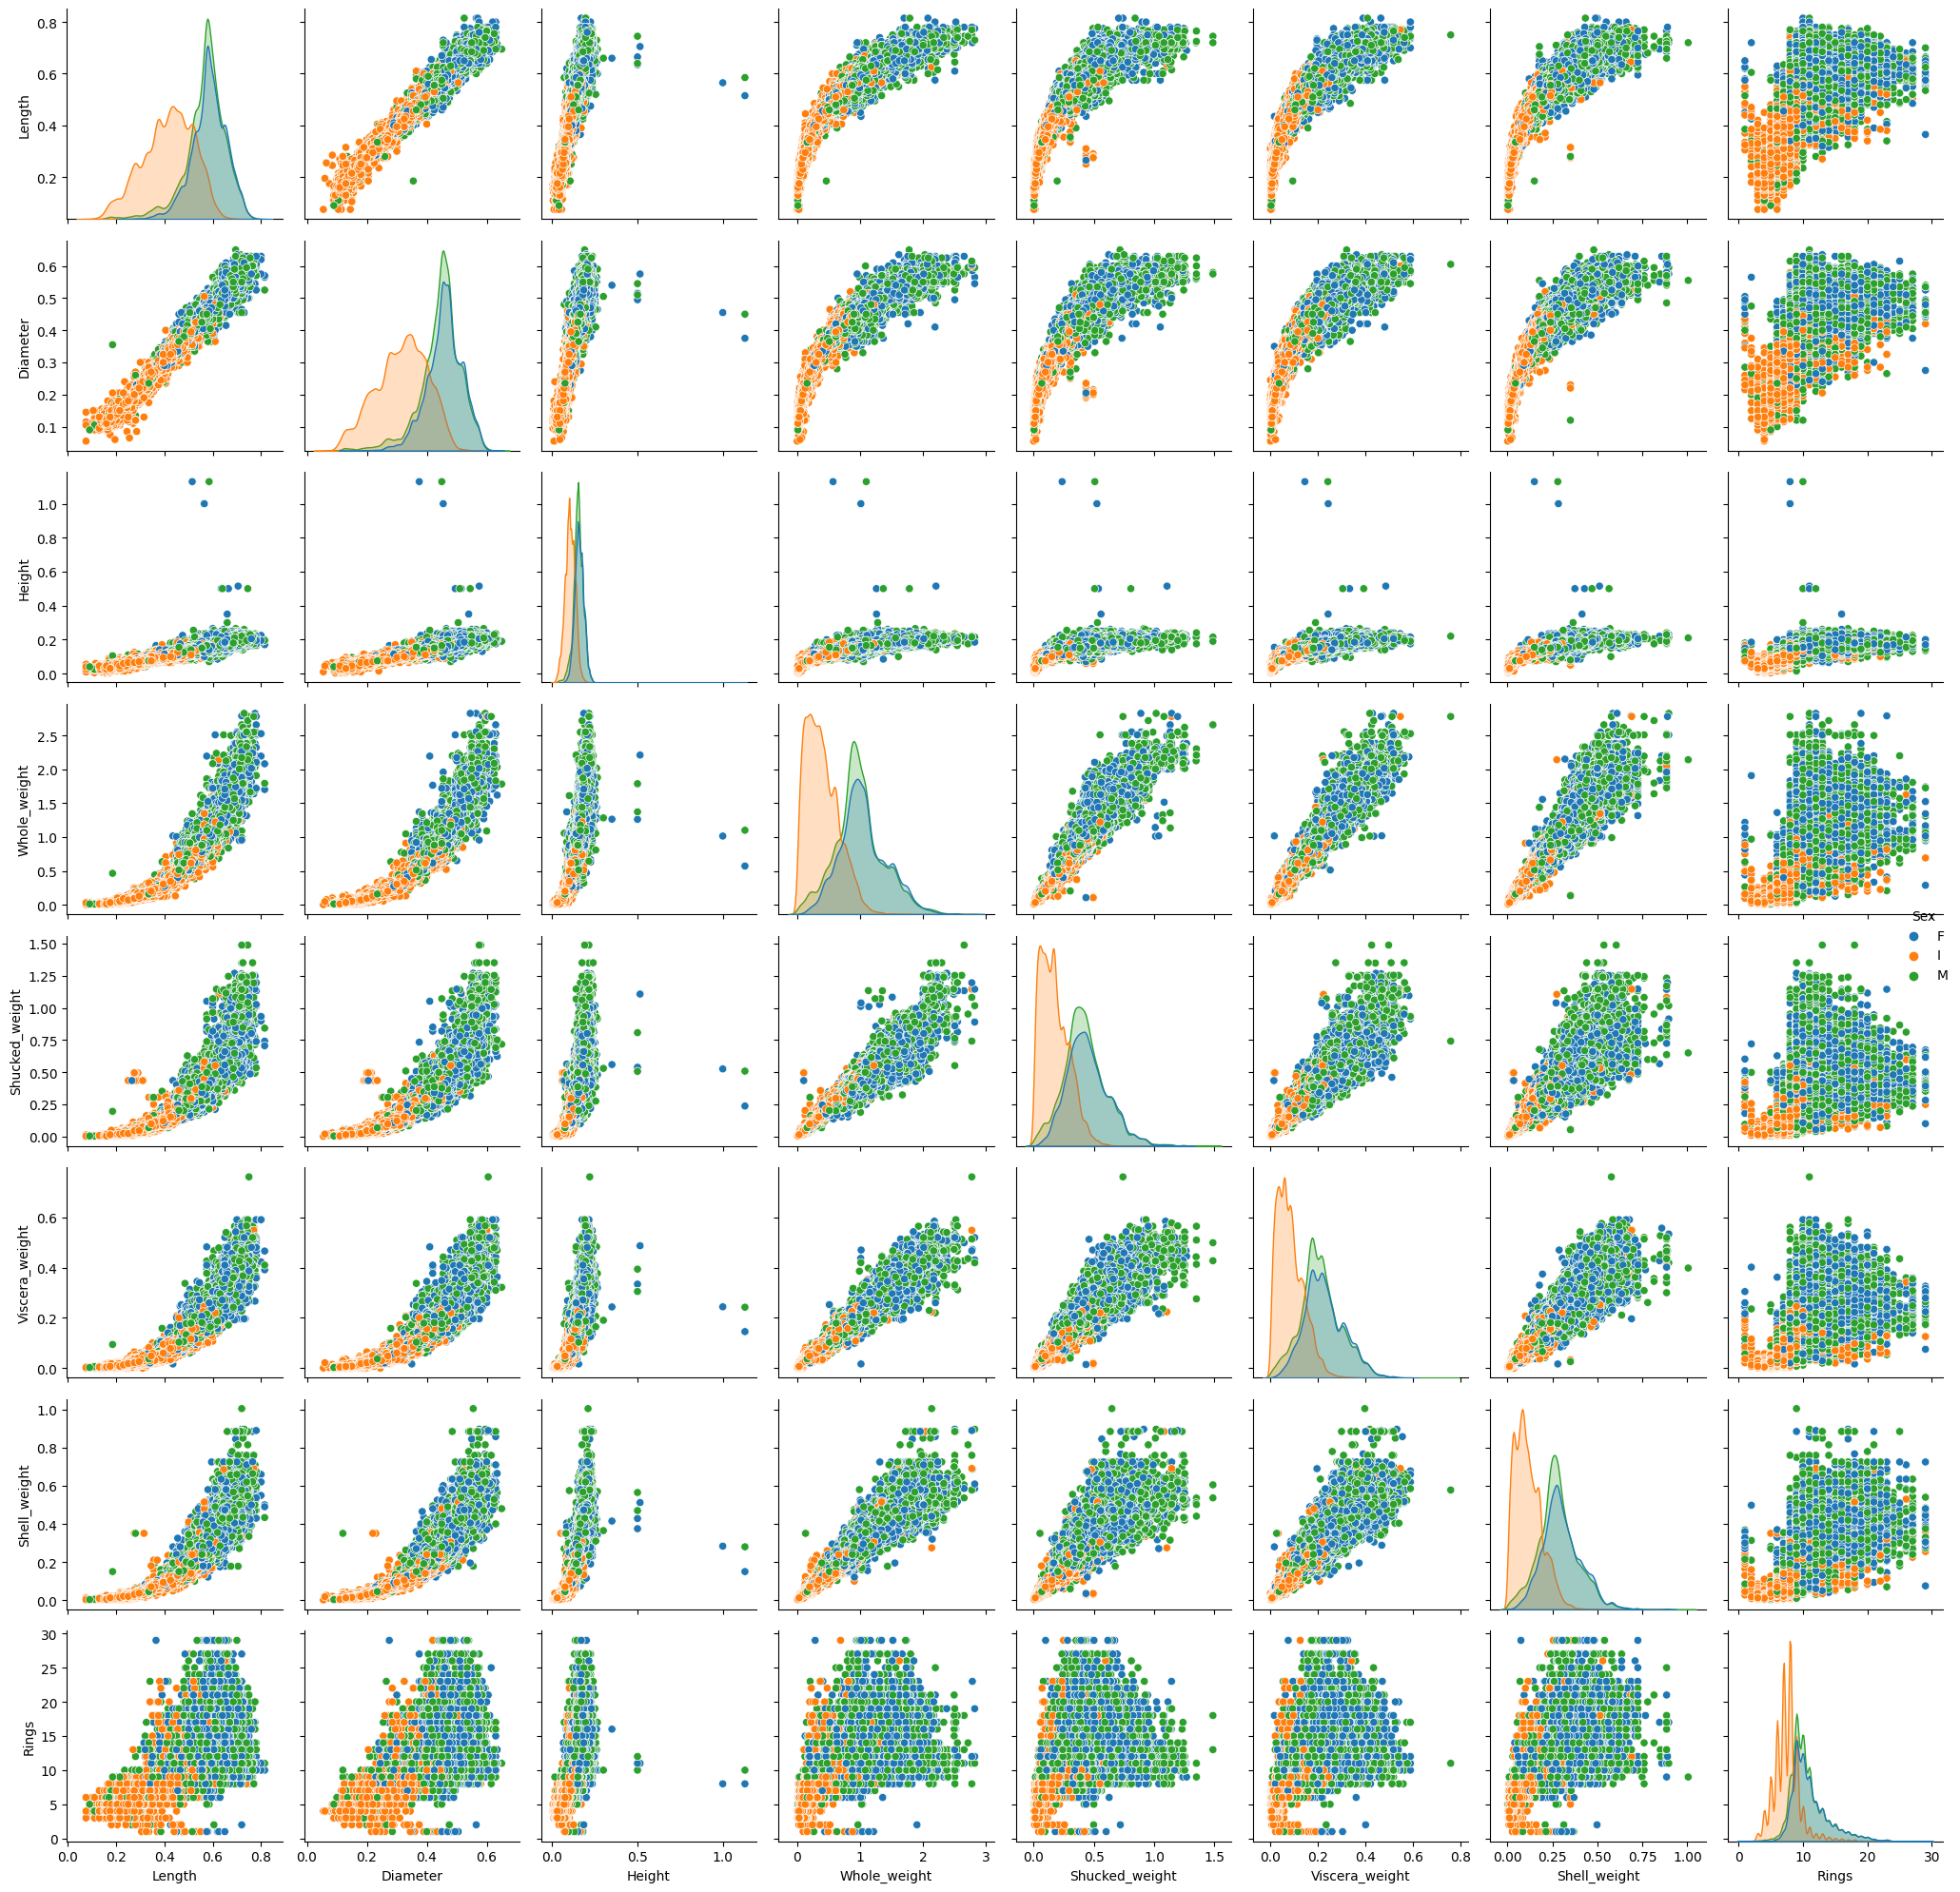

In [16]:
cont_cols = ['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']
target = ['Rings']

# Set up the pairplot 
g = sns.pairplot(
    data=train,
    vars=cont_cols + target,
    hue='Sex'
)
plt.tight_layout()
plt.show()

## 5.4 Look at scatter plots with linear regression lines of variables vs rings 

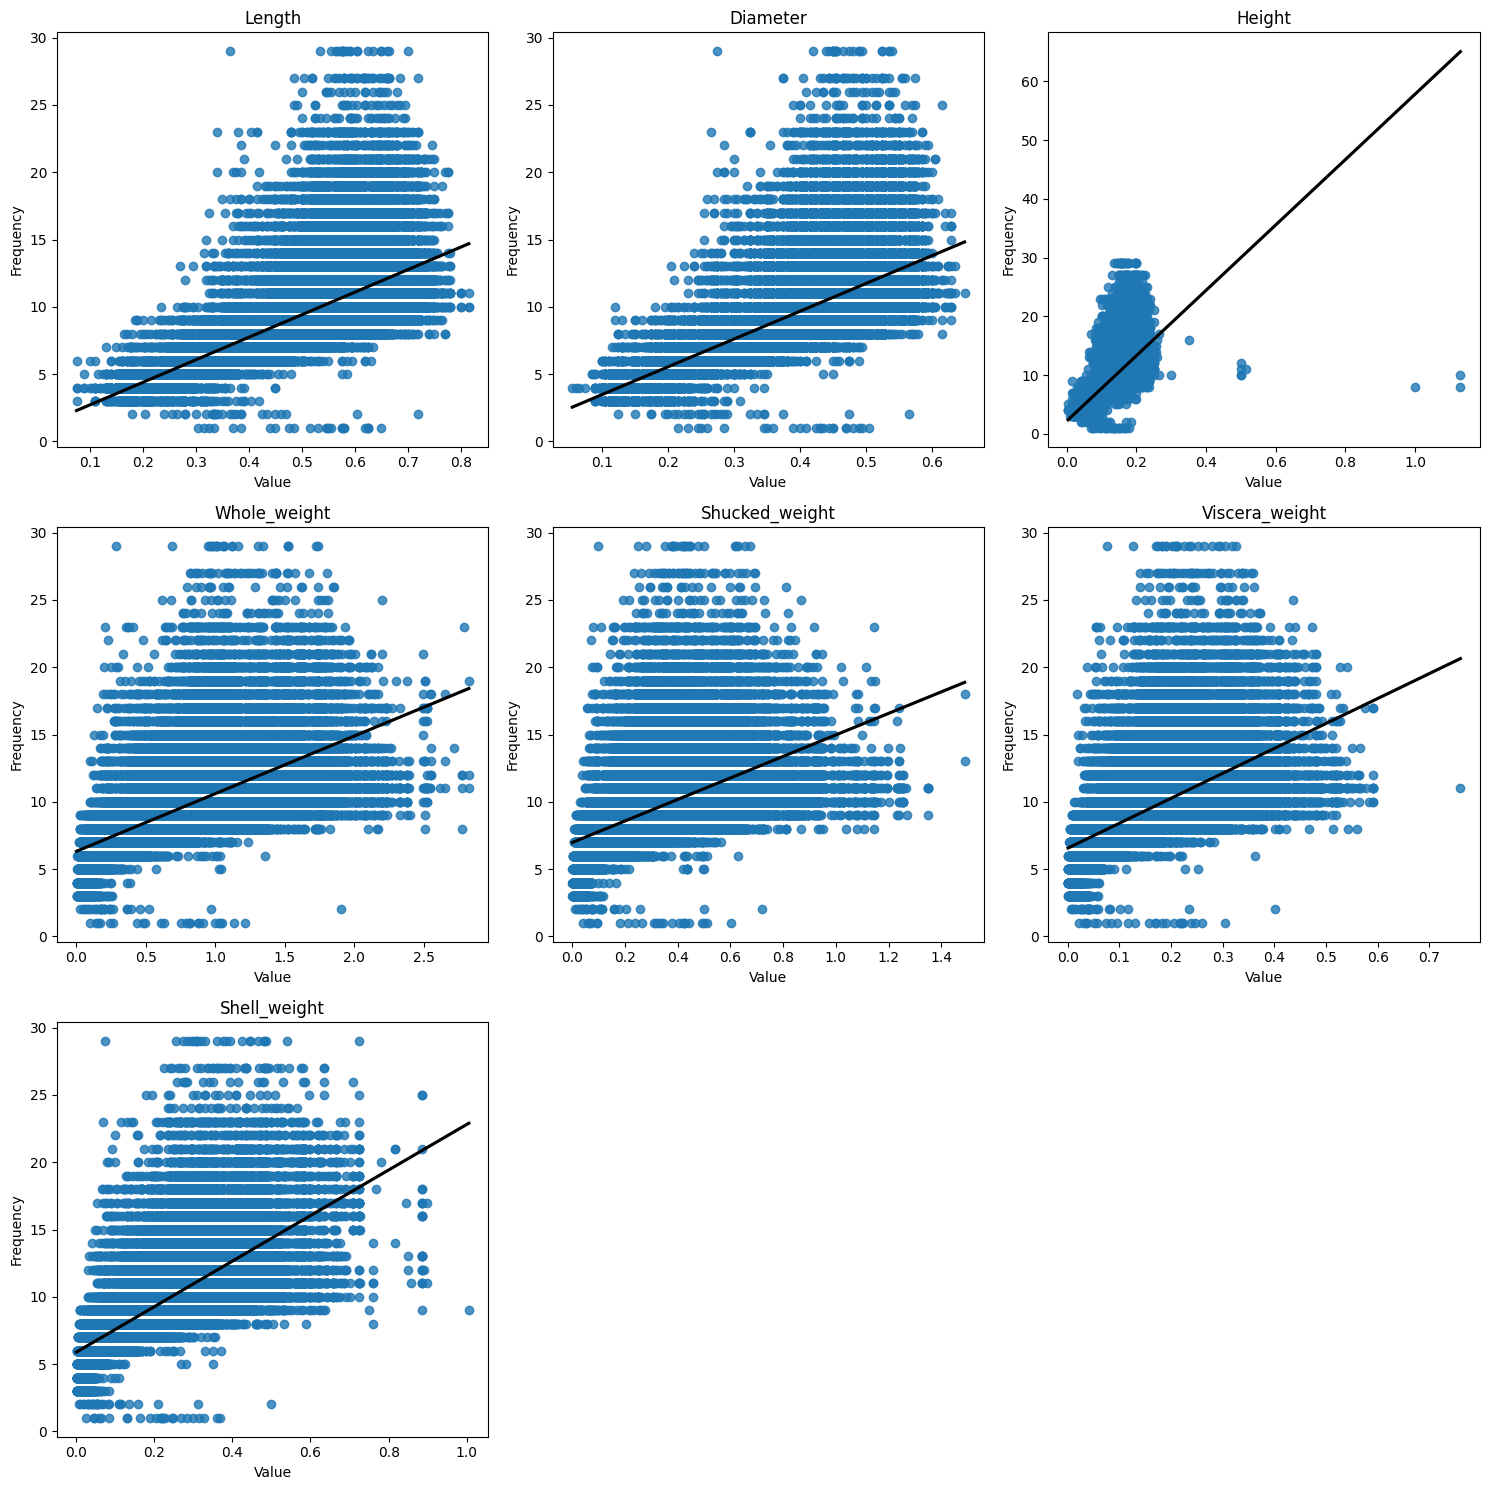

In [17]:
cont_cols = ['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']

# Calculate the number of rows needed for the subplots
num_rows = (len(cont_cols) + 2) // 3

# Create subplots for each continuous column
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows*5))

# Loop through each continuous column and plot the regression plots
for i, col in enumerate(cont_cols):
  
    # Calculate the subplot position
    row = i // 3
    col_pos = i % 3
    
    #create the plot
    sns.regplot( data=train[col], x= train[col] , y= train['Rings'], ci=False, line_kws={'color': 'black'}, ax=axs[row][col_pos])
    axs[row][col_pos].set_title(col)
    axs[row][col_pos].set_xlabel('Value')
    axs[row][col_pos].set_ylabel('Frequency')

        # Remove any empty subplots
if len(cont_cols) % 3 != 0:
    for col_pos in range(len(cont_cols) % 3, 3):
        axs[-1][col_pos].remove()

plt.tight_layout()
plt.show()


## 5.5 Look at the rings compared the the sex 

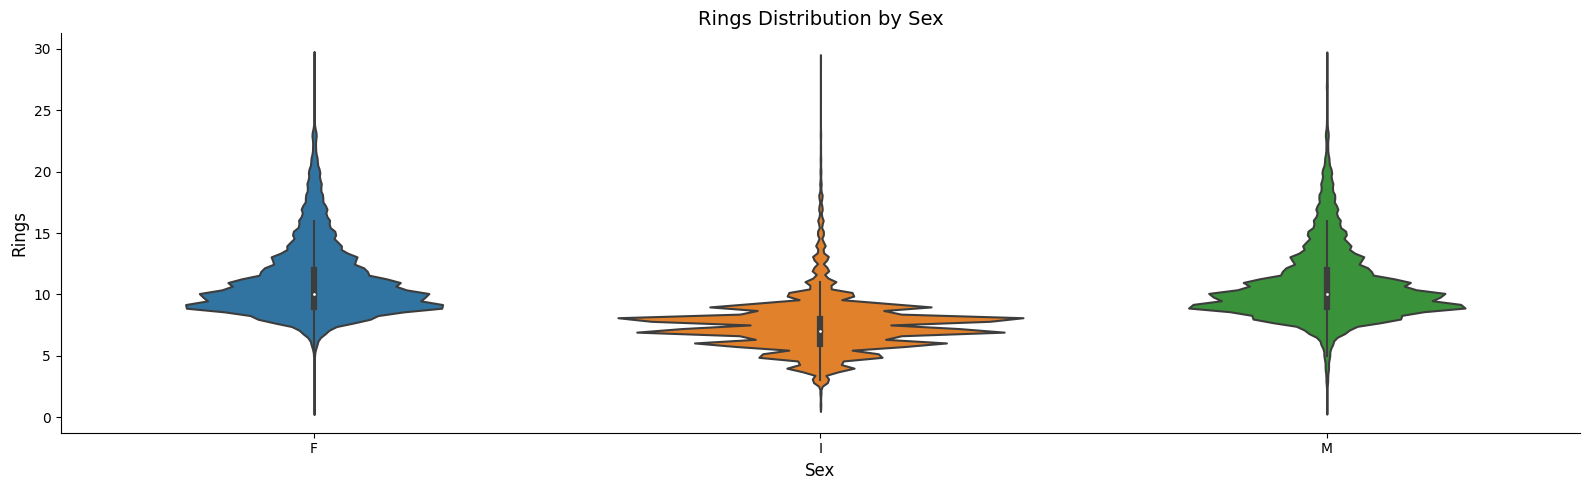

In [18]:
plt.subplots(figsize=(16, 5))
sns.violinplot(x='Sex', y='Rings', data=train)
plt.title('Rings Distribution by Sex', fontsize=14)
plt.xlabel('Sex', fontsize=12)
plt.ylabel('Rings', fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()

## 5.6 Create a coorelation plot for all variables 

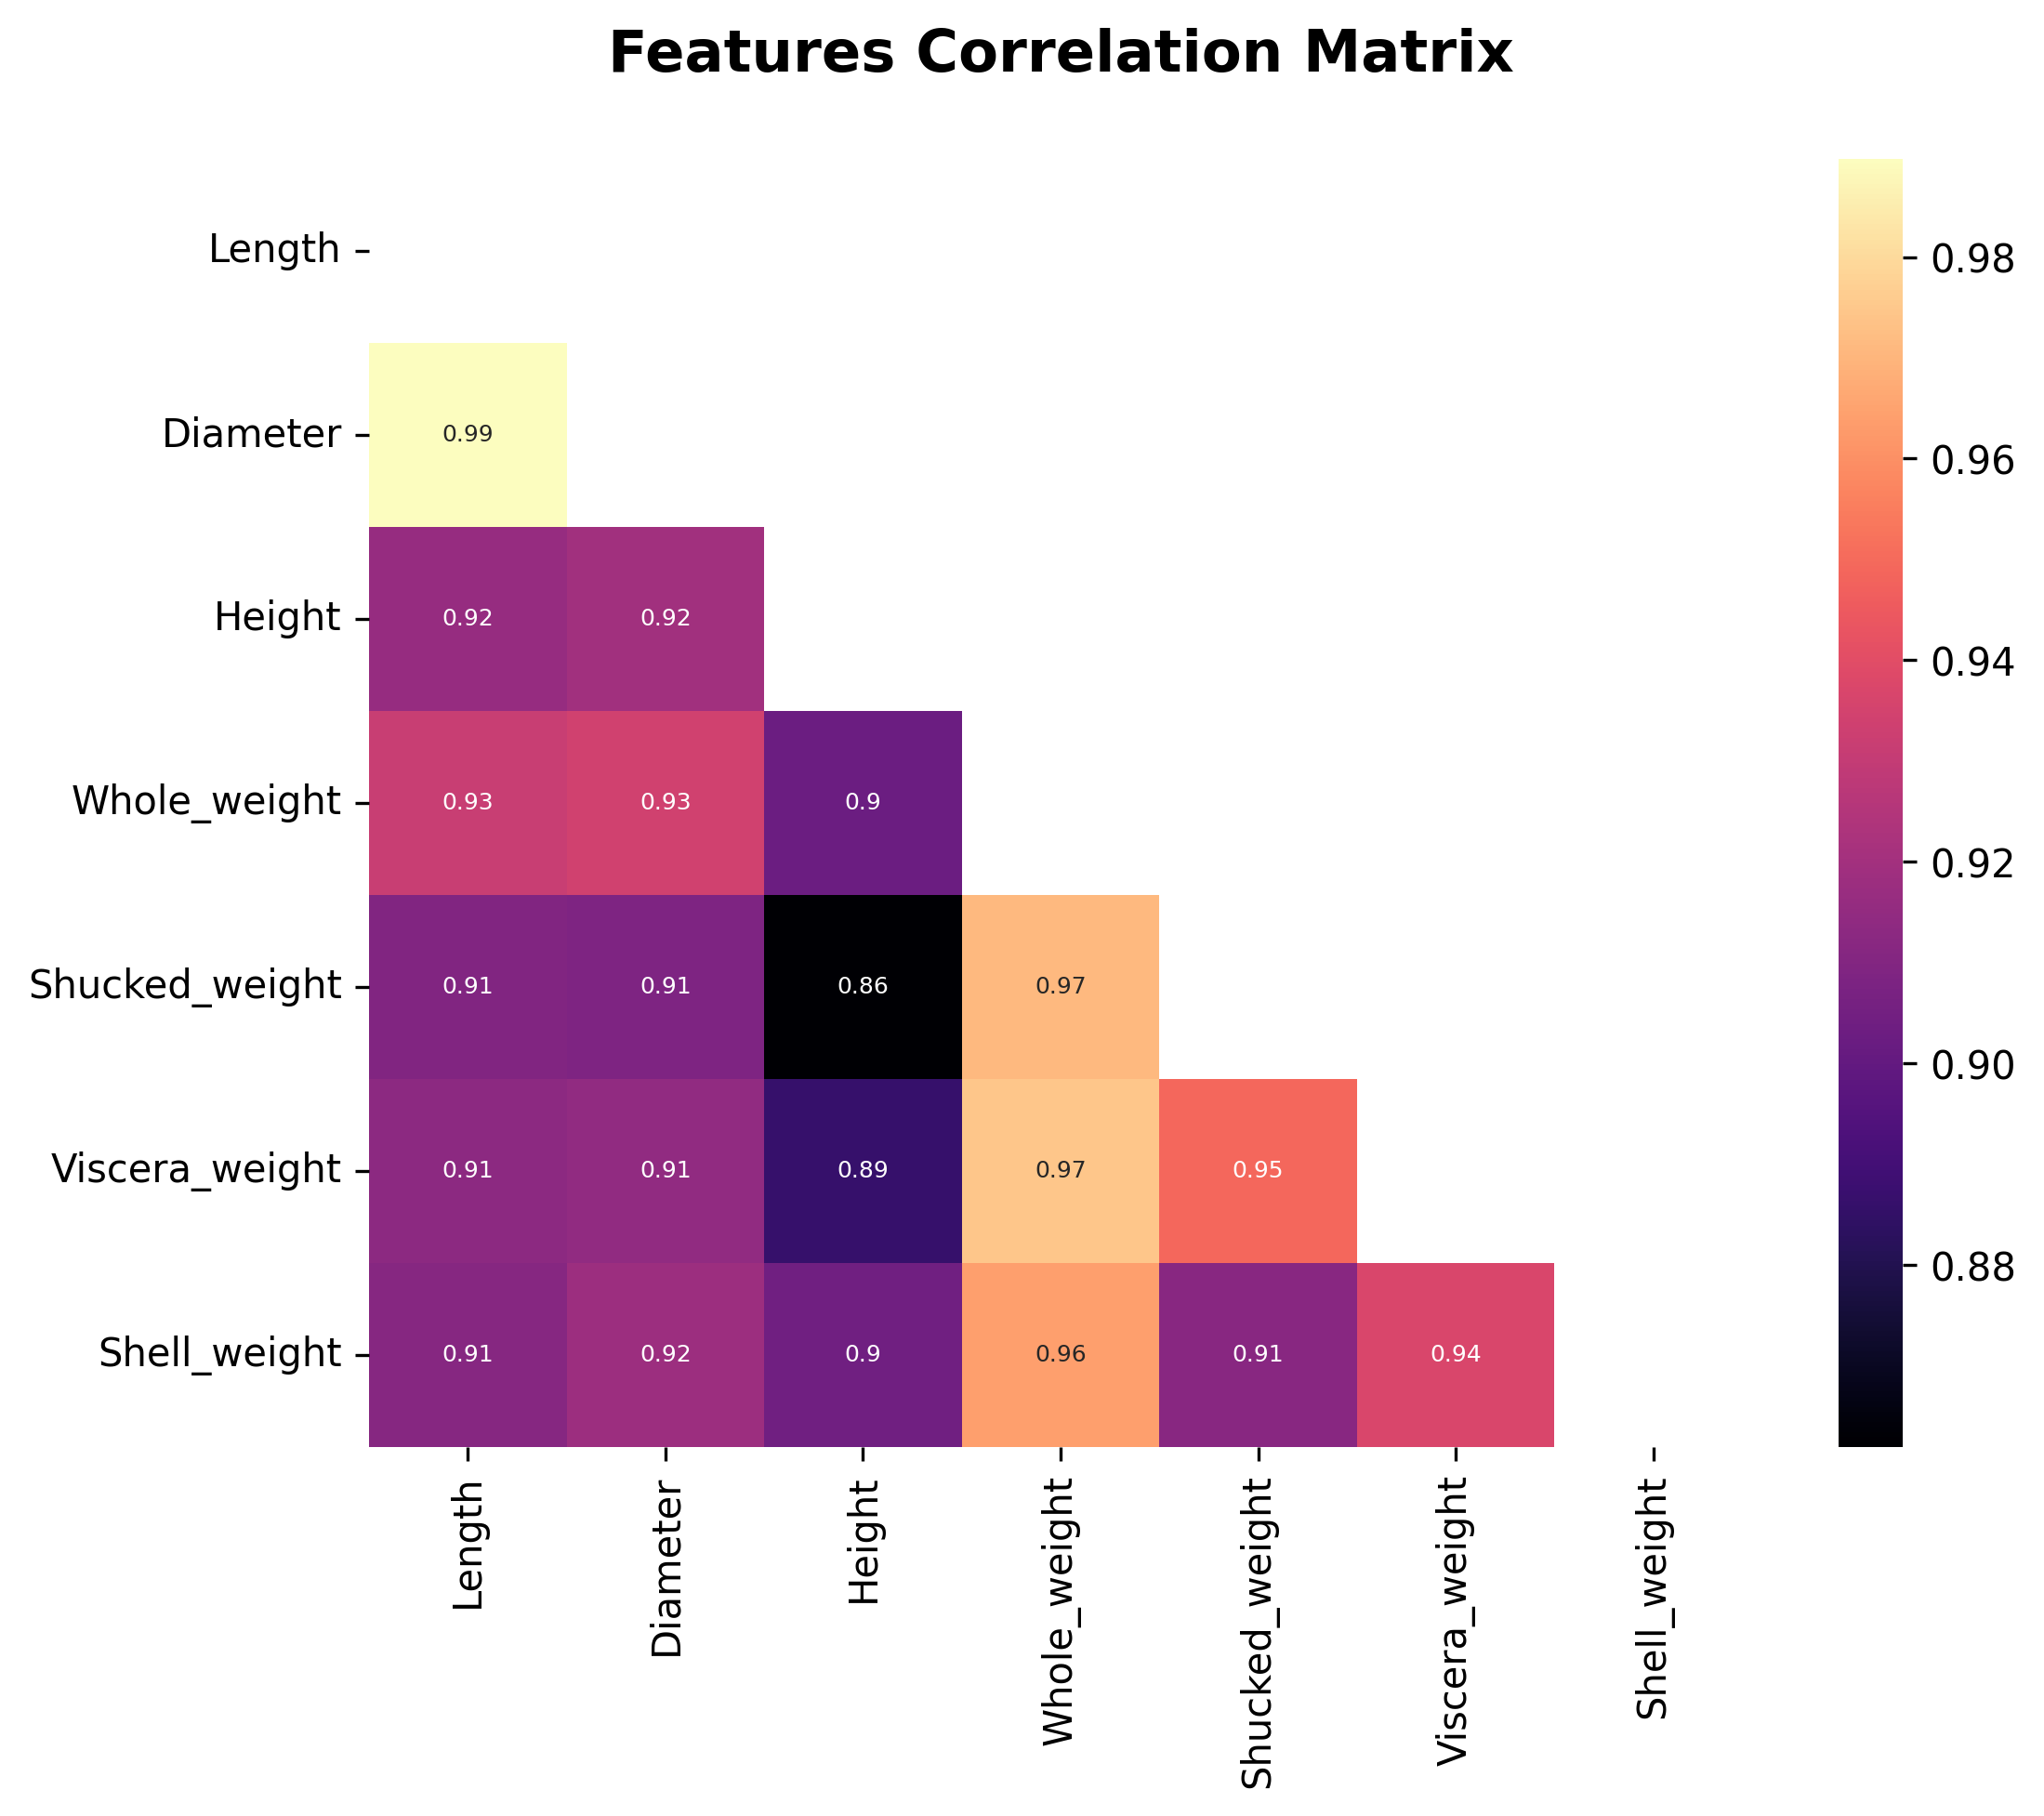

In [19]:
features= predict_col
corr = train[features].corr()
plt.figure(figsize = (8, 6), dpi = 300)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask, cmap = 'magma', annot = True, annot_kws = {'size' : 6})
plt.title('Features Correlation Matrix\n', fontsize = 15, weight = 'bold')
plt.show()

# 6. Split Datasets for Train, Validate, and Test

In [20]:
# Define features and target
cont_cols = [
    'Length','Diameter','Height',
    'Whole_weight','Shucked_weight',
    'Viscera_weight','Shell_weight'
]
target = 'Rings'

X = train[cont_cols]
y = train[target]

# Split 
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# 7. Explore Regression Models

## 7.1 Start Multiple linear regression with all continuous predictors 

In [21]:
# Add constant, fit on training
Xf_train = sm.add_constant(X_train)
model_full = sm.OLS(y_train, Xf_train).fit()

# Print Summary
print("=== Full MLR on Training Set ===")
print(model_full.summary())

=== Full MLR on Training Set ===
                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                 1.561e+04
Date:                Fri, 08 Aug 2025   Prob (F-statistic):               0.00
Time:                        01:05:39   Log-Likelihood:            -1.5330e+05
No. Observations:               72487   AIC:                         3.066e+05
Df Residuals:                   72479   BIC:                         3.067e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const      

In [22]:
# Check evaluation metrics
Xf_val = sm.add_constant(X_val)
y_pred_full = model_full.predict(Xf_val)
y_pred_full_clipped = np.clip(y_pred_full, a_min=0, a_max=None)

r2_full    = r2_score(y_val, y_pred_full)
rmse_full  = np.sqrt(mean_squared_error(y_val, y_pred_full))
rmsle_full = np.sqrt(mean_squared_log_error(y_val, y_pred_full_clipped))

print("FULL MLR EVALUATION (validation set)")
print(f"  R²    = {r2_full:.4f}")
print(f"  RMSE  = {rmse_full:.4f}")
print(f"  RMSLE = {rmsle_full:.4f}")

FULL MLR EVALUATION (validation set)
  R²    = 0.5922
  RMSE  = 2.0292
  RMSLE = 0.1671


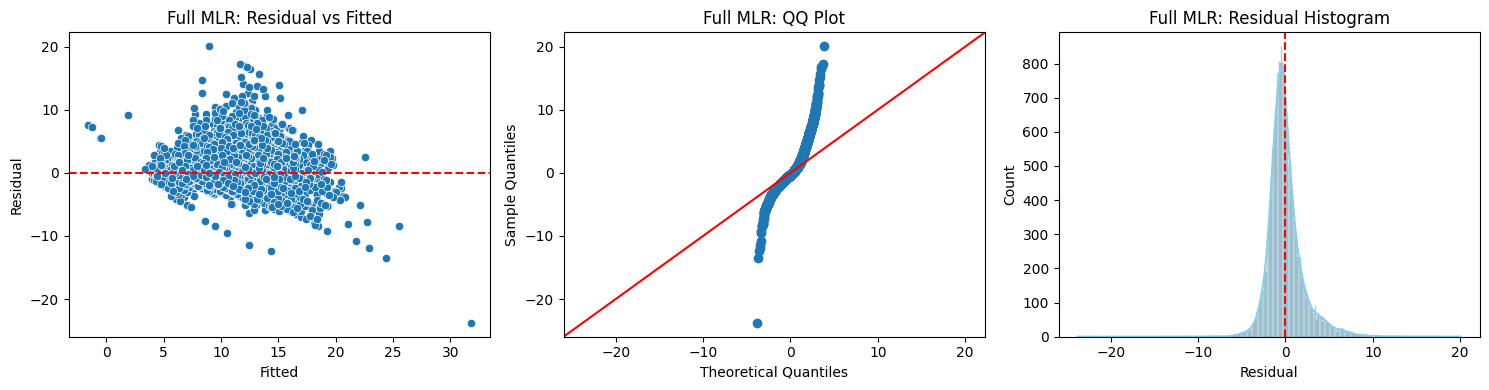

In [23]:
# Validation predictions & residuals
y_val_pred_full = model_full.predict(Xf_val)
resid_val_full  = y_val - y_val_pred_full

# Residual diagnostics on Validation dataset- create subplot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Residual vs Fitted
sns.scatterplot(x=y_val_pred_full, y=resid_val_full, ax=axes[0])
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set(title='Full MLR: Residual vs Fitted',
            xlabel='Fitted', ylabel='Residual')

#  QQ plot
sm.qqplot(resid_val_full, line='45', ax=axes[1])
axes[1].set(title='Full MLR: QQ Plot')

# Histogram
sns.histplot(resid_val_full, kde=True, ax=axes[2], color='skyblue')
axes[2].axvline(0, color='red', linestyle='--')
axes[2].set(title='Full MLR: Residual Histogram', xlabel='Residual')

plt.tight_layout()
plt.show()

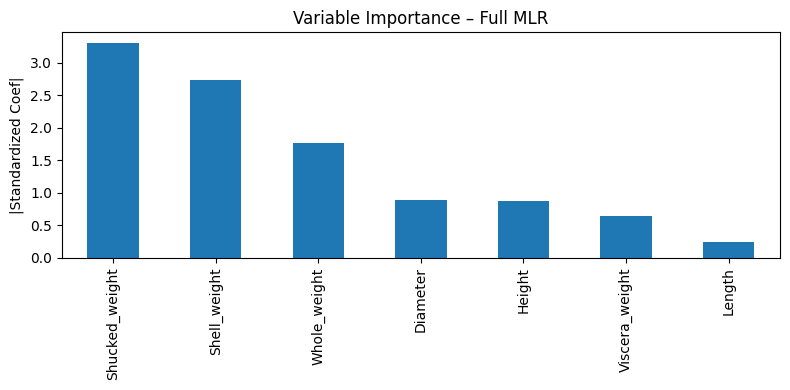

In [24]:
# Standardize full MLR predictors, preserving index
scaler_full = StandardScaler()
Xf_arr = scaler_full.fit_transform(X_train)
Xf_scaled = pd.DataFrame(
    Xf_arr,
    index=X_train.index,         # <— keep the same index
    columns=X_train.columns
)
Xf_scaled = sm.add_constant(Xf_scaled)

model_full_std = sm.OLS(y_train, Xf_scaled).fit()
coefs_full = model_full_std.params.drop('const')
importance_full = coefs_full.abs().sort_values(ascending=False)

plt.figure(figsize=(8,4))
importance_full.plot(kind='bar')
plt.title('Variable Importance – Full MLR')
plt.ylabel('|Standardized Coef|')
plt.tight_layout()
plt.show()

## 7.2 Start Polynomial Regression 

In [25]:
# 1) Specify your four continuous predictors & Rings target
cont_cols = ['Shucked_weight','Shell_weight','Whole_weight','Height']
X = train[cont_cols]
y = train['Rings']

# 2) Fit OLS for polynomial degrees 1 through 4
degrees = [1, 2, 3, 4]
polys, fits = [], []
for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=False)
    Xd   = poly.fit_transform(X)
    mod  = sm.OLS(y, sm.add_constant(Xd)).fit()
    polys.append(poly)
    fits.append(mod)

# 3) ANOVA to test added nonlinearity
print("\nANOVA across polynomial degrees 1→4:\n")
print(anova_lm(*fits))




ANOVA across polynomial degrees 1→4:

   df_resid            ssr  df_diff       ss_diff           F         Pr(>F)
0   90604.0  372059.434931      0.0           NaN         NaN            NaN
1   90594.0  343162.693715     10.0  28896.741217  788.571806   0.000000e+00
2   90574.0  336168.271978     20.0   6994.421737   95.436432   0.000000e+00
3   90539.0  331774.739234     35.0   4393.532744   34.256122  1.502700e-227


In [26]:

# Evaluate on validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

metrics = []
for d, poly, fit in zip(degrees, polys, fits):
    Xv = poly.transform(X_val)
    pred = fit.predict(sm.add_constant(Xv))
    clip = np.clip(pred, 0, None)
    metrics.append({
        'degree': d,
        'R2':    r2_score(y_val, pred),
        'RMSE':  np.sqrt(mean_squared_error(y_val, pred)),
        'RMSLE': np.sqrt(mean_squared_log_error(y_val, clip))
    })
df_metrics = pd.DataFrame(metrics).set_index('degree')
print("\nValidation metrics by polynomial degree:\n", df_metrics)




Validation metrics by polynomial degree:
               R2      RMSE     RMSLE
degree                              
1       0.584667  2.047846  0.169776
2       0.621534  1.954846  0.159859
3       0.628604  1.936503  0.157423
4       0.634663  1.920640  0.155881


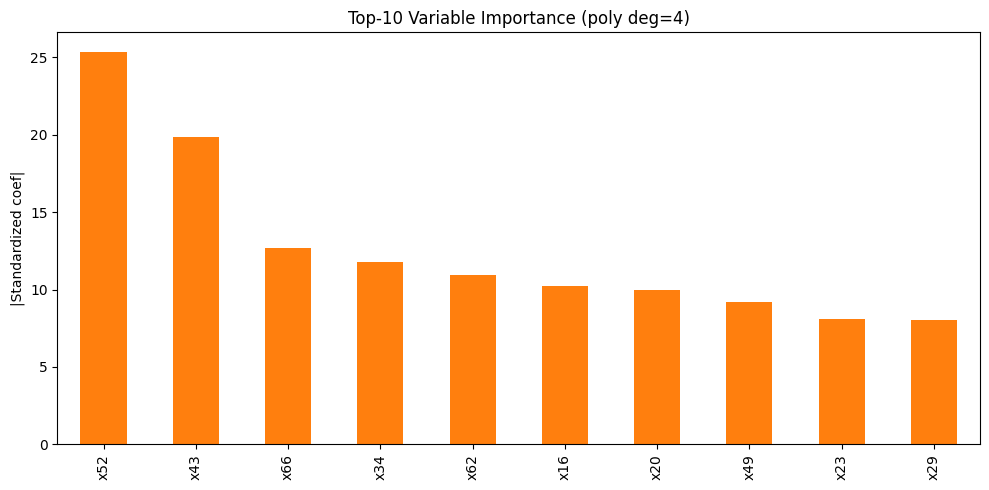


=== Summary of Validation Performance ===
              R2      RMSE     RMSLE
degree                              
1       0.584667  2.047846  0.169776
2       0.621534  1.954846  0.159859
3       0.628604  1.936503  0.157423
4       0.634663  1.920640  0.155881


In [27]:
# standardize X_train
scaler_X = StandardScaler().fit(X_train)
X_train_std = pd.DataFrame(scaler_X.transform(X_train),
                           columns=cont_cols)

poly4     = PolynomialFeatures(degree=4, include_bias=False)
Xp4_train = poly4.fit_transform(X_train_std)
feat4     = poly4.get_feature_names_out(cont_cols)

scaler_Xp4 = StandardScaler().fit(Xp4_train)
Xp4_std    = scaler_Xp4.transform(Xp4_train)

#  fit OLS 
mod4_std = sm.OLS(y_train, sm.add_constant(Xp4_std)).fit()

#  plot the top‐10 coefs
coefs4 = mod4_std.params.drop('const')
imp4   = coefs4.abs().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
imp4.plot(kind='bar', color='C1')
plt.title('Top-10 Variable Importance (poly deg=4)')
plt.ylabel('|Standardized coef|')
plt.tight_layout()
plt.show()


# validation metrics table 
print("\n=== Summary of Validation Performance ===")
print(df_metrics)

# 8. Hot Encode and Feature Engineering 

In [28]:
# One-hot encode 'Sex'
train_encoded = pd.get_dummies(train, columns=['Sex'], drop_first=False)
test_encoded = pd.get_dummies(test, columns=['Sex'], drop_first=False)

# Ensure all Sex categories exist
for col in ['Sex_F','Sex_M','Sex_I']:
    if col not in train_encoded.columns:
        train_encoded[col] = 0
    if col not in test_encoded.columns:
        test_encoded[col] = 0

# Feature Engineering
eps = 1e-6
def engineer_features(df):
    df['meat_ratio'] = df['Shucked_weight'] / (df['Whole_weight'] + eps)
    df['viscera_ratio'] = df['Viscera_weight'] / (df['Whole_weight'] + eps)
    df['shell_ratio'] = df['Shell_weight'] / (df['Whole_weight'] + eps)
    df['meat_to_shell_ratio'] = df['Shucked_weight'] / (df['Shell_weight'] + eps)
    df['viscera_to_meat_ratio'] = df['Viscera_weight'] / (df['Shucked_weight'] + eps)
    df['volume'] = df['Length'] * df['Diameter'] * df['Height']
    df['density'] = df['Whole_weight'] / (df['volume'] + eps)
    df['log_whole_weight'] = np.log(df['Whole_weight'] + eps)
    return df

train_encoded = engineer_features(train_encoded)
test_encoded = engineer_features(test_encoded)

# Align test columns
for c in set(train_encoded.columns) - set(test_encoded.columns) - {'Rings'}:
    test_encoded[c] = 0

# Features and target
feature_cols = [c for c in train_encoded.columns if c != 'Rings']
# Convert data to numeric to avoid object dtype issues in statsmodels
train_X = train_encoded[feature_cols].astype(float)
train_y = train_encoded['Rings'].astype(float)
test_X = test_encoded[feature_cols].astype(float)

# Split and scale
X_train, X_val, y_train, y_val = train_test_split(
    train_X, train_y, test_size=0.2, random_state=42
)
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train),
                              columns=feature_cols, index=X_train.index)
X_val_scaled   = pd.DataFrame(scaler.transform(X_val),
                              columns=feature_cols, index=X_val.index)
test_X_scaled  = pd.DataFrame(scaler.transform(test_X),
                              columns=feature_cols, index=test_X.index)

# log transform Y
train_y_log = np.log(train_y + 1.5)
y_val_log = np.log(y_val + 1.5)

In [29]:
feature_cols = [c for c in train_encoded.columns if c != 'Rings']
X = train_encoded[feature_cols].astype(float)
y = train_encoded['Rings'].astype(float)


# Split & scale
X_train, X_val, y_train, y_val = train_test_split(
    train_X, train_y, test_size=0.2, random_state=42
)
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train),
                              columns=feature_cols, index=X_train.index)
X_val_scaled   = pd.DataFrame(scaler.transform(X_val),
                              columns=feature_cols, index=X_val.index)
test_X_scaled  = pd.DataFrame(scaler.transform(test_X),
                              columns=feature_cols, index=test_X.index)



# 9. Regularization Models and Principal Componenets Regression 

## 9.1 Fit Regularization Models (Lasso, Ridge, ElasticNet)

In [30]:
lasso   = LassoCV(cv=5, random_state=42).fit(X_train_scaled, y_train)
ridge   = RidgeCV(alphas=np.logspace(-4,4,100), cv=5).fit(X_train_scaled, y_train)
elastic = ElasticNetCV(cv=5, random_state=42).fit(X_train_scaled, y_train)

print(f"Chosen α: Ridge={ridge.alpha_:.4f}, Lasso={lasso.alpha_:.4f}, "
      f"ElasticNet={elastic.alpha_:.4f}, l1_ratio={elastic.l1_ratio_:.2f}")

# Make predictions on validation set 
preds = {
    'Lasso':      lasso.predict(X_val_scaled),
    'Ridge':      ridge.predict(X_val_scaled),
    'ElasticNet': elastic.predict(X_val_scaled)
}

Chosen α: Ridge=0.0001, Lasso=0.0022, ElasticNet=0.0044, l1_ratio=0.50


## 9.2 Fit Principal Components Regression (PCR)

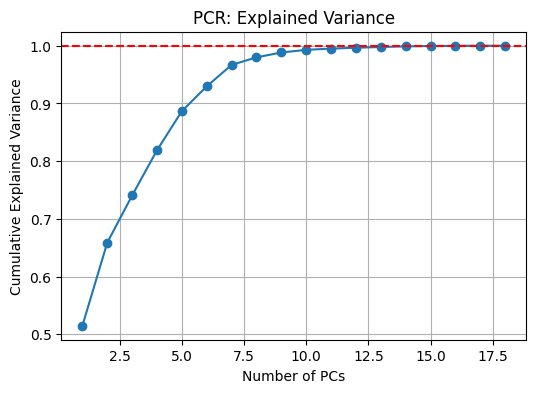

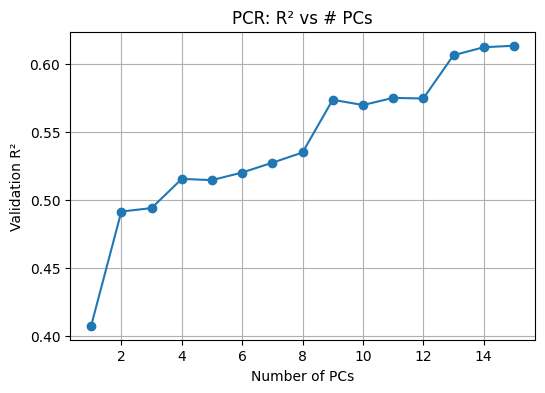

In [31]:
dimensions = len(feature_cols)
pca_full = PCA(n_components=dimensions).fit(X_train_scaled)
explained = np.cumsum(pca_full.explained_variance_ratio_)
plt.figure(figsize=(6,4))
plt.plot(range(1, dimensions+1), explained, marker='o')
plt.axhline(1.0, color='red', linestyle='--')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCR: Explained Variance')
plt.grid()
plt.show()

# Validation R² vs number of PCs
max_pcs = min(15, dimensions)
r2_vals = []
for k in range(1, max_pcs+1):
    pca_k = PCA(n_components=k)
    Xk = pca_k.fit_transform(X_train_scaled)
    Vk = pca_k.transform(X_val_scaled)
    lr = LinearRegression().fit(Xk, y_train)
    r2_vals.append(r2_score(y_val, lr.predict(Vk)))

plt.figure(figsize=(6,4))
plt.plot(range(1, max_pcs+1), r2_vals, marker='o')
plt.xlabel('Number of PCs')
plt.ylabel('Validation R²')
plt.title('PCR: R² vs # PCs')
plt.grid()
plt.show()

In [32]:
pca14   = PCA(n_components=14).fit(X_train_scaled)
Xp14    = pca14.transform(X_train_scaled)
Xv14    = pca14.transform(X_val_scaled)
lr_pcr  = LinearRegression().fit(Xp14, y_train)
preds['PCR'] = lr_pcr.predict(Xv14)

## 9.3 Review Model Performance 

In [33]:
# Lasso OLS summary
lasso_feats = [f for f, coef in zip(feature_cols, lasso.coef_) if coef != 0]
X_lasso = add_constant(X_train_scaled[lasso_feats])
model_lasso = OLS(y_train, X_lasso).fit()

# Ridge OLS summary (top 10 by abs(coef))
ridge_feats = pd.Series(ridge.coef_, index=feature_cols).abs().nlargest(10).index.tolist()
X_ridge = add_constant(X_train_scaled[ridge_feats])
model_ridge = OLS(y_train, X_ridge).fit()

# ElasticNet OLS summary
enet_feats = [f for f, coef in zip(feature_cols, elastic.coef_) if coef != 0]
X_elastic = add_constant(X_train_scaled[enet_feats])
model_elastic = OLS(y_train, X_elastic).fit()

# PCR OLS summary (first 3 PCs)
pca3 = PCA(n_components=3).fit(X_train_scaled)
X3_train = pd.DataFrame(
    pca3.transform(X_train_scaled),
    index=X_train_scaled.index,
    columns=['PC1','PC2','PC3']
)
model_pcr = OLS(y_train, add_constant(X3_train)).fit()

In [34]:
# Predict 
y_pred = {
    'Lasso':     model_lasso.predict(add_constant(X_val_scaled[lasso_feats])),
    'Ridge':     model_ridge.predict(add_constant(X_val_scaled[ridge_feats])),
    'ElasticNet':model_elastic.predict(add_constant(X_val_scaled[enet_feats])),
    'PCR (3PCs)':model_pcr.predict(
                     add_constant(
                       pd.DataFrame(
                         pca3.transform(X_val_scaled),
                         columns=['PC1','PC2','PC3'],
                         index=X_val_scaled.index
                       )
                     )
                   )
}

In [35]:
# Get the summary
summary = []
for name, pred in y_pred.items():
    clip = np.clip(pred, 0, None)
    summary.append({
        'Model': name,
        'R2':    r2_score(y_val, pred),
        'RMSE':  np.sqrt(mean_squared_error(y_val, pred)),
        'RMSLE': np.sqrt(mean_squared_log_error(y_val, clip))
    })
df_summary = pd.DataFrame(summary).set_index('Model')

# Print


print("\n=== Regularization & PCR Comparison ===")
print(df_summary)

print("\n=== Lasso OLS Summary ===")
print(model_lasso.summary())

print("\n=== Ridge OLS Summary ===")
print(model_ridge.summary())

print("\n=== ElasticNet OLS Summary ===")
print(model_elastic.summary())

print("\n=== PCR (3 PCs) OLS Summary ===")
print(model_pcr.summary())


=== Regularization & PCR Comparison ===
                  R2      RMSE     RMSLE
Model                                   
Lasso       0.614985  1.971686  0.160133
Ridge       0.609345  1.986076  0.163985
ElasticNet  0.614985  1.971686  0.160133
PCR (3PCs)  0.493828  2.260728  0.188946

=== Lasso OLS Summary ===
                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     7007.
Date:                Fri, 08 Aug 2025   Prob (F-statistic):               0.00
Time:                        01:06:01   Log-Likelihood:            -1.5139e+05
No. Observations:               72487   AIC:                         3.028e+05
Df Residuals:                   72469   BIC:                         3.030e+05
Df Model:                          17                 

# 10. Non-Linear Regression Models 

## 10.1 Log Transform Y and Refit Models

In [36]:
# Log‐transform both targets
y_train_log = np.log(y_train + 1.5)
y_val_log   = np.log(y_val   + 1.5)

# Fit new models
lasso_log   = LassoCV(cv=5, random_state=42).fit(X_train_scaled, y_train_log)
ridge_log   = RidgeCV(alphas=np.logspace(-4,4,100), cv=5).fit(X_train_scaled, y_train_log)
elastic_log = ElasticNetCV(cv=5, random_state=42).fit(X_train_scaled, y_train_log)

# Predict in log‐space on X_val_scaled
y_pred_lasso_log   = lasso_log.predict(X_val_scaled)
y_pred_ridge_log   = ridge_log.predict(X_val_scaled)
y_pred_elastic_log = elastic_log.predict(X_val_scaled)

# Back‐transform to original Rings scale
y_pred_lasso   = np.exp(y_pred_lasso_log)   - 1.5
y_pred_ridge   = np.exp(y_pred_ridge_log)   - 1.5
y_pred_elastic = np.exp(y_pred_elastic_log) - 1.5

# Evaluate 
def eval(y_true, y_pred, name):
    clip = np.clip(y_pred, 0, None)
    return {
        'model': name,
        'R2':    r2_score(y_true, y_pred),
        'RMSE':  np.sqrt(mean_squared_error(y_true, y_pred)),
        'RMSLE': np.sqrt(mean_squared_log_error(y_true, clip))
    }

results_log = [
    eval(y_val, y_pred_lasso,   'Lasso (log‐target)'),
    eval(y_val, y_pred_ridge,   'Ridge (log‐target)'),
    eval(y_val, y_pred_elastic, 'ElasticNet (log‐target)')
]

df_log = pd.DataFrame(results_log).set_index('model')
print(df_log)

                               R2      RMSE     RMSLE
model                                                
Lasso (log‐target)       0.599079  2.012004  0.158708
Ridge (log‐target)       0.597804  2.015200  0.158624
ElasticNet (log‐target)  0.599187  2.011731  0.158716


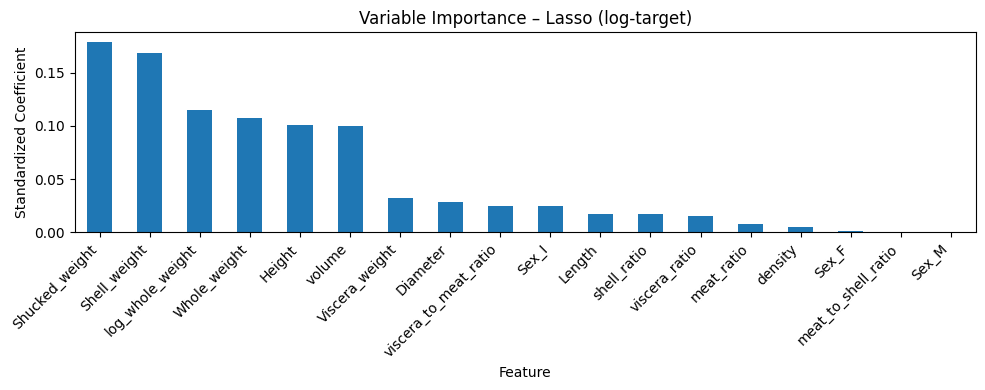

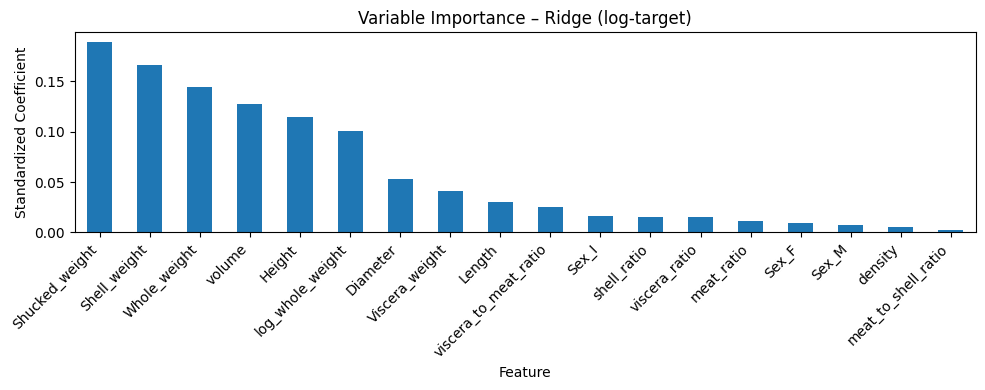

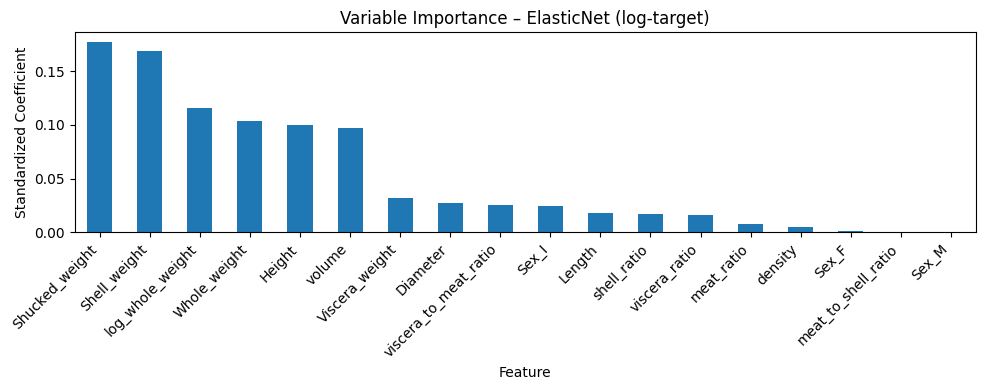

In [37]:
# Look at the varaible importance 
models_log = {
    'Lasso (log-target)':   lasso_log,
    'Ridge (log-target)':   ridge_log,
    'ElasticNet (log-target)': elastic_log
}

for name, model in models_log.items():
    # Extract and sort by absolute value
    coefs = pd.Series(model.coef_, index=feature_cols)
    importance = coefs.abs().sort_values(ascending=False)
    
    # Bar plot
    plt.figure(figsize=(10,4))
    importance.plot(kind='bar')
    plt.title(f'Variable Importance – {name}')
    plt.ylabel('Standardized Coefficient')
    plt.xlabel('Feature')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

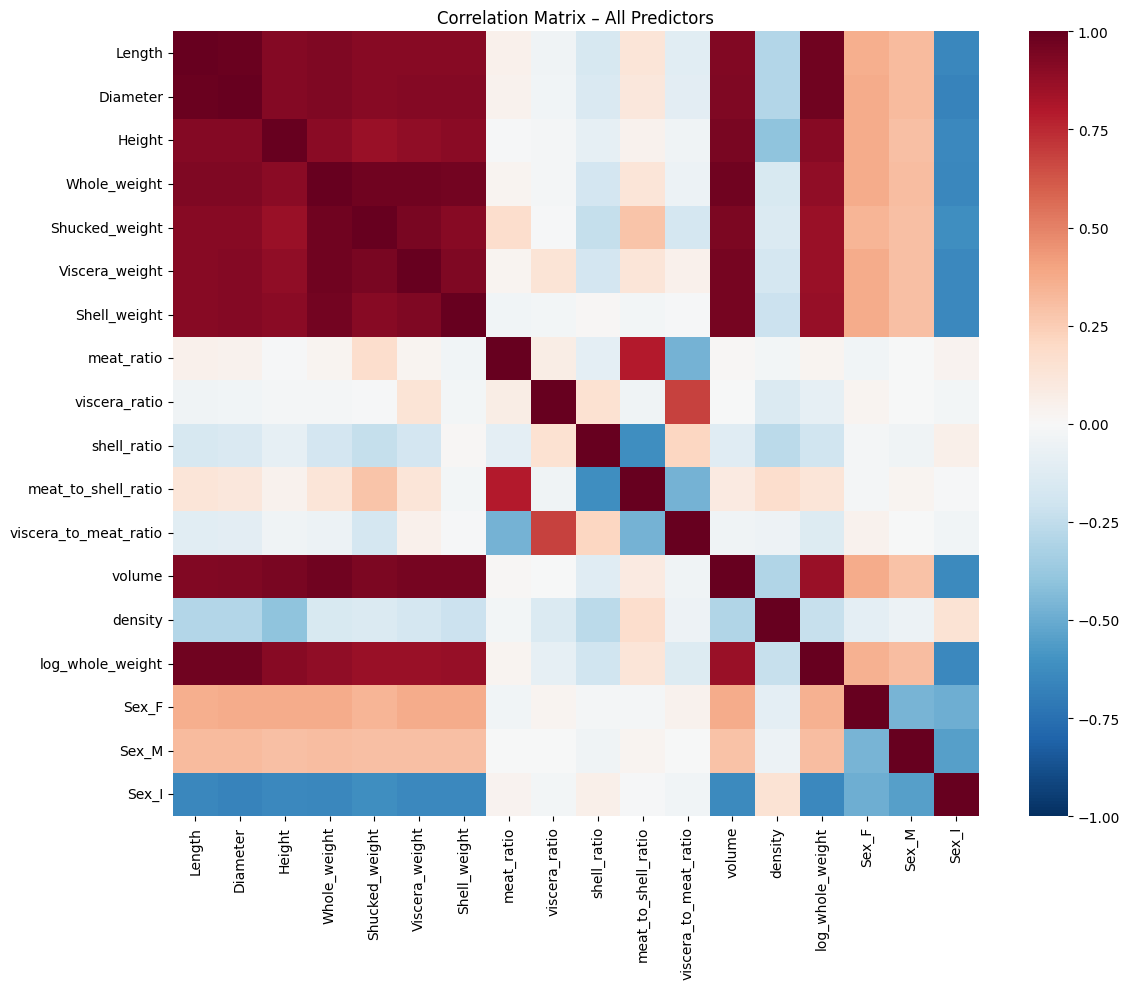

In [38]:
# Get corr def
corr_df = pd.concat([
    X_train_scaled[[
        'Length','Diameter','Height',
        'Whole_weight','Shucked_weight','Viscera_weight','Shell_weight'
    ]],
    train_encoded.loc[X_train_scaled.index, [
        'meat_ratio','viscera_ratio','shell_ratio',
        'meat_to_shell_ratio','viscera_to_meat_ratio',
        'volume','density','log_whole_weight',
        'Sex_F','Sex_M','Sex_I'
    ]]
], axis=1)

# coerce and drop any infinite / NaN rows
corr_df = corr_df.apply(pd.to_numeric, errors='coerce')
corr_df.replace([np.inf, -np.inf], np.nan, inplace=True)
corr_df.dropna(inplace=True)

# correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr_df.corr(), cmap='RdBu_r', center=0, vmin=-1, vmax=1)
plt.title("Correlation Matrix – All Predictors")
plt.tight_layout()
plt.show()

In [39]:
# Grab features and dummies
all_feats = [
    'Length','Diameter','Height',
    'Whole_weight','Shucked_weight','Viscera_weight','Shell_weight',
    'meat_ratio','viscera_ratio','shell_ratio',
    'meat_to_shell_ratio','viscera_to_meat_ratio',
    'volume','density','log_whole_weight',
    'Sex_F','Sex_M','Sex_I'
]
corr_df = train_encoded[all_feats]  

# Keep  numeric dtypes and force to float
corr_df = corr_df.select_dtypes(include=[np.number]).astype('float64')

# Replace infinities
corr_df.replace([np.inf, -np.inf], np.nan, inplace=True)
corr_df.dropna(axis=0, how='any', inplace=True)

# add an intercept
corr_const = add_constant(corr_df)

# Compute VIF on each feature (skip the constant)
vif_data = []
for i, col in enumerate(corr_const.columns):
    if col == 'const':
        continue
    vif_data.append({
        'feature': col,
        'VIF': variance_inflation_factor(corr_const.values, i)
    })

vif_df = pd.DataFrame(vif_data).sort_values('VIF', ascending=False)
print(vif_df.round(1))

                  feature    VIF
12                 volume  132.6
3            Whole_weight  124.6
14       log_whole_weight  100.5
0                  Length   80.2
1                Diameter   78.3
2                  Height   44.7
4          Shucked_weight   44.4
6            Shell_weight   42.4
5          Viscera_weight   42.2
10    meat_to_shell_ratio   16.4
7              meat_ratio   10.4
9             shell_ratio    5.8
11  viscera_to_meat_ratio    5.1
8           viscera_ratio    4.6
13                density    2.4


In [40]:
keep = [
    'log_whole_weight',
    'Shell_weight',     
    'meat_ratio','viscera_ratio','shell_ratio',
    'meat_to_shell_ratio','viscera_to_meat_ratio',
    'density',
    'Sex_F','Sex_M','Sex_I'
]
df_vif = train_encoded[keep].select_dtypes(float)\
           .replace([np.inf,-np.inf], np.nan).dropna()
df_vif = add_constant(df_vif)

vif = pd.DataFrame({
    'feature': df_vif.columns,
    'VIF': [variance_inflation_factor(df_vif.values, i)
            for i in range(df_vif.shape[1])]
}).query("feature != 'const'").sort_values('VIF', ascending=False)

print(vif.round(1))

                 feature   VIF
6    meat_to_shell_ratio  14.5
3             meat_ratio   9.6
1       log_whole_weight   5.4
5            shell_ratio   5.4
2           Shell_weight   5.0
7  viscera_to_meat_ratio   4.0
4          viscera_ratio   3.0
8                density   1.2


## 10.2 Start Natural Spline Model 

In [41]:
# Define the diagnotics for spline models 
def plot_diagnostics_spline(model, spline_df, y_true, title):

    # Predict on log‐scale, back‐transform
    Xc = sm.add_constant(spline_df)
    y_log_pred = model.predict(Xc)
    y_pred     = np.exp(y_log_pred) - 1.5

    # residuals
    resid = y_true - y_pred

    # set up grid
    fig, axes = plt.subplots(1,3, figsize=(15,4))
    fig.suptitle(f"Diagnostics: {title}", fontsize=16)

    # Residuals vs. Fitted
    sns.scatterplot(x=y_pred, y=resid, alpha=0.3, ax=axes[0])
    axes[0].axhline(0, color='red', linestyle='--')
    axes[0].set_xlabel("Fitted values")
    axes[0].set_ylabel("Residuals")
    axes[0].set_title("Residuals vs. Fitted")

    # Normal Q–Q
    sm.qqplot(resid, line='45', ax=axes[1])
    axes[1].set_title("Normal Q–Q")

    # Scale–Location
    sns.scatterplot(x=y_pred, y=np.sqrt(np.abs(resid)), alpha=0.3, ax=axes[2])
    axes[2].axhline(0, color='red', linestyle='--')
    axes[2].set_xlabel("Fitted values")
    axes[2].set_ylabel("Residuals")
    axes[2].set_title("Scale–Location")

    plt.tight_layout(rect=[0,0.03,1,0.95])
    plt.show()


In [42]:
# Build a natural spline basis with df=5 on Shucked_weight
spline_train = dmatrix(
    "bs(Shucked_weight, df=5, degree=3, include_intercept=False)",
    data=X_train_scaled.assign(Shucked_weight=X_train['Shucked_weight']),
    return_type='dataframe'
)
spline_val = dmatrix(
    "bs(Shucked_weight, df=5, degree=3, include_intercept=False)",
    data=X_val_scaled.assign(Shucked_weight=X_val['Shucked_weight']),
    return_type='dataframe'
)

# Fit OLS on log-target
mod_spline = sm.OLS(y_train_log, sm.add_constant(spline_train)).fit()
print(mod_spline.summary())

# Predict, back-transform, evaluate
pred_log_train = mod_spline.predict(sm.add_constant(spline_train))
pred_log_val   = mod_spline.predict(sm.add_constant(spline_val))

pred_train = np.exp(pred_log_train) - 1.5
pred_val   = np.exp(pred_log_val)   - 1.5

def eval_preds(y_true, y_pred):
    clip = np.clip(y_pred, 0, None)
    return {
        'R2':    r2_score(y_true, y_pred),
        'RMSE':  np.sqrt(mean_squared_error(y_true, y_pred)),
        'RMSLE': np.sqrt(mean_squared_log_error(y_true, clip))
    }

print("\n— Natural Spline (Shucked_weight) performance —")
print(" Train:", eval_preds(y_train, pred_train))
print("  Val :", eval_preds(y_val,   pred_val))



                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                 1.360e+04
Date:                Fri, 08 Aug 2025   Prob (F-statistic):               0.00
Time:                        01:06:16   Log-Likelihood:                 15590.
No. Observations:               72487   AIC:                        -3.117e+04
Df Residuals:                   72481   BIC:                        -3.111e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

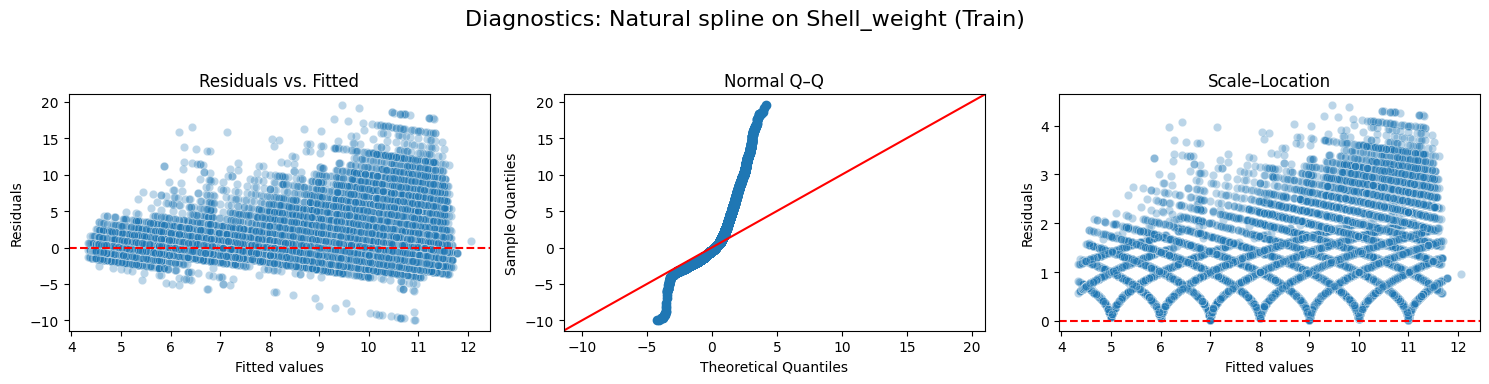

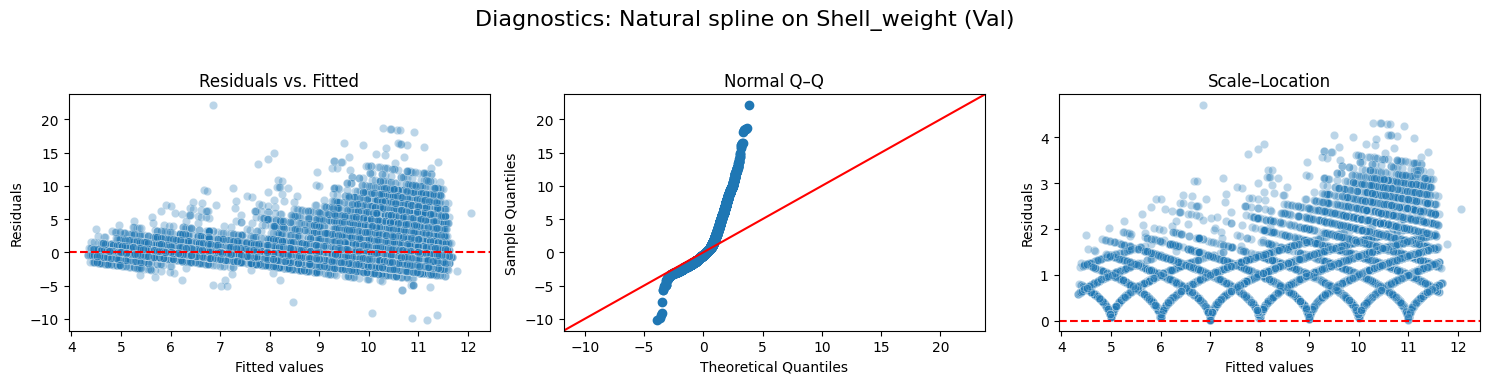

In [43]:
# Shucked_weight spline Plots
plot_diagnostics_spline(
    model    = mod_spline,           
    spline_df= spline_train,          
    y_true   = y_train,              
    title    = "Natural spline on Shell_weight (Train)"
)

plot_diagnostics_spline(
    model    = mod_spline,
    spline_df= spline_val,
    y_true   = y_val,
    title    = "Natural spline on Shell_weight (Val)"
)


In [44]:
# Build a natural spline basis with df=5 on Shell_weight
spline_train_s = dmatrix(
    "bs(Shell_weight, df=5, degree=3, include_intercept=False)",
    data=X_train_scaled.assign(Shell_weight=X_train['Shell_weight']),
    return_type='dataframe'
)
spline_val_s = dmatrix(
    "bs(Shell_weight, df=5, degree=3, include_intercept=False)",
    data=X_val_scaled.assign(Shell_weight=X_val['Shell_weight']),
    return_type='dataframe'
)

# Fit OLS on log-target
mod_spline_s = sm.OLS(y_train_log, sm.add_constant(spline_train_s)).fit()
print(mod_spline_s.summary())

# Predict, back-transform, evaluate
pred_log_train_s = mod_spline_s.predict(sm.add_constant(spline_train_s))
pred_log_val_s   = mod_spline_s.predict(sm.add_constant(spline_val_s))

pred_train_s = np.exp(pred_log_train_s) - 1.5
pred_val_s   = np.exp(pred_log_val_s)   - 1.5

def eval_preds(y_true, y_pred):
    clip = np.clip(y_pred, 0, None)
    return {
        'R2':    r2_score(y_true, y_pred),
        'RMSE':  np.sqrt(mean_squared_error(y_true, y_pred)),
        'RMSLE': np.sqrt(mean_squared_log_error(y_true, clip))
    }

print("\n— Natural Spline (Shell_weight) performance —")
print(" Train:", eval_preds(y_train, pred_train_s))
print("  Val :", eval_preds(y_val,   pred_val_s))



                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                 2.250e+04
Date:                Fri, 08 Aug 2025   Prob (F-statistic):               0.00
Time:                        01:06:19   Log-Likelihood:                 25553.
No. Observations:               72487   AIC:                        -5.109e+04
Df Residuals:                   72481   BIC:                        -5.104e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

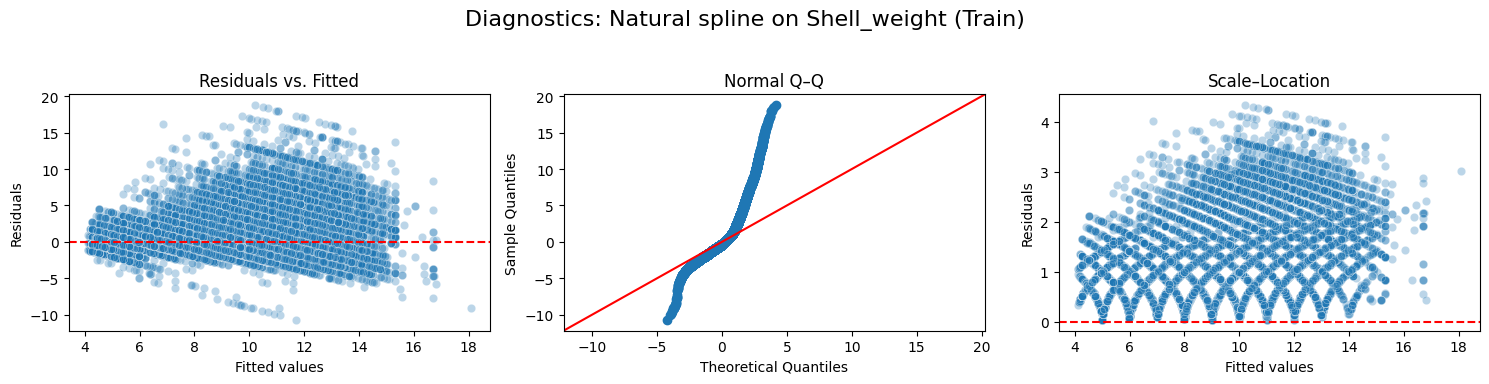

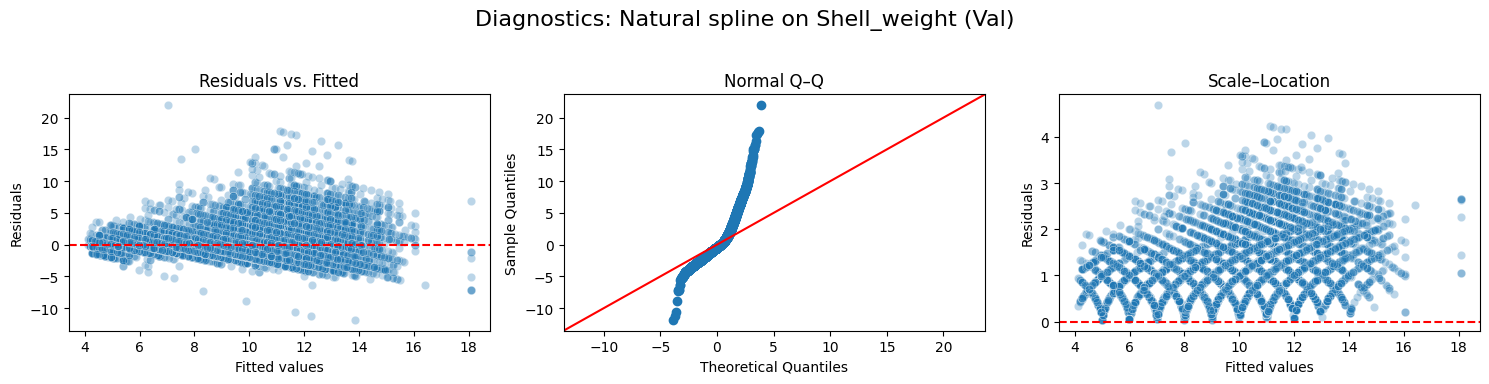

In [45]:
# Shucked_weight spline Plots
plot_diagnostics_spline(
    model    = mod_spline_s,           
    spline_df= spline_train_s,          
    y_true   = y_train,              
    title    = "Natural spline on Shell_weight (Train)"
)

plot_diagnostics_spline(
    model    = mod_spline_s,
    spline_df= spline_val_s,
    y_true   = y_val,
    title    = "Natural spline on Shell_weight (Val)"
)


In [46]:
# Natural spline basis with df=5 on Height
spline_train_H = dmatrix(
    "bs(Height, df=5, degree=3, include_intercept=False)",
    data=X_train_scaled.assign(Height=X_train['Height']),
    return_type='dataframe'
)
spline_val_H = dmatrix(
    "bs(Height, df=5, degree=3, include_intercept=False)",
    data=X_val_scaled.assign(Shucked_weight=X_val['Height']),
    return_type='dataframe'
)

# Fit OLS on log-target
mod_spline_h = sm.OLS(y_train_log, sm.add_constant(spline_train_H)).fit()
print(mod_spline.summary())

# Predict, back-transform, evaluate
pred_log_train_H = mod_spline_h.predict(sm.add_constant(spline_train_H))
pred_log_val_H   = mod_spline_h.predict(sm.add_constant(spline_val_H))

pred_train_H = np.exp(pred_log_train_H) - 1.5
pred_val_H   = np.exp(pred_log_val_H)   - 1.5

def eval_preds(y_true, y_pred):
    clip = np.clip(y_pred, 0, None)
    return {
        'R2':    r2_score(y_true, y_pred),
        'RMSE':  np.sqrt(mean_squared_error(y_true, y_pred)),
        'RMSLE': np.sqrt(mean_squared_log_error(y_true, clip))
    }

print("\n— Natural Spline (Height) performance —")
print(" Train:", eval_preds(y_train, pred_train_H))
print("  Val :", eval_preds(y_val,   pred_val_H))



                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                 1.360e+04
Date:                Fri, 08 Aug 2025   Prob (F-statistic):               0.00
Time:                        01:06:22   Log-Likelihood:                 15590.
No. Observations:               72487   AIC:                        -3.117e+04
Df Residuals:                   72481   BIC:                        -3.111e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

## 10.3 Start Generalized Additive Model

In [47]:
# log‐transform the target
y_train_log = np.log(y_train + 1.5)
y_val_log   = np.log(y_val   + 1.5)

# pick only the cleaned features (no Viscera_weight, Whole_weight→log_whole_weight)
num_feats   = ['Shucked_weight', 'Shell_weight', 'log_whole_weight', 'Height']
dummy_feats = ['Sex_F', 'Sex_M', 'Sex_I']

# build design matrices for GAM
Xg_train = np.column_stack([
    X_train[num_feats].values,
    X_train[dummy_feats].values
])
Xg_val = np.column_stack([
    X_val[  num_feats].values,
    X_val[  dummy_feats].values
])

# fit the multivariate GAM on log‐target
gam_multi = LinearGAM(
    s(0, n_splines=10) +  # Shucked_weight
    s(1, n_splines=10) +  # Shell_weight
    s(2, n_splines=10) +  # log_whole_weight
    s(3, n_splines=10) +  # Height
    f(4) + f(5) + f(6)    # Sex_F, Sex_M, Sex_I
).gridsearch(Xg_train, y_train_log)

# summary
print(gam_multi.summary())

# predict & back‐transform
pred_train_log = gam_multi.predict(Xg_train)
pred_val_log   = gam_multi.predict(Xg_val)

pred_train = np.exp(pred_train_log) - 1.5
pred_val   = np.exp(pred_val_log)   - 1.5

# evaluation helper
def eval_preds(y_true, y_pred):
    clip = np.clip(y_pred, 0, None)
    return {
      'R2':    round(r2_score(y_true, y_pred),4),
      'RMSE':  round(np.sqrt(mean_squared_error(y_true, y_pred)),4),
      'RMSLE': round(np.sqrt(mean_squared_log_error(y_true, clip)),4)
    }

print("\n— MULTIVARIATE GAM performance —")
print(" Train:", eval_preds(y_train, pred_train))
print("  Val :", eval_preds(y_val,   pred_val))

100% (11 of 11) |########################| Elapsed Time: 0:00:12 Time:  0:00:12
/tmp/ipykernel_13/1118410221.py:29: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam_multi.summary())


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     33.4928
Link Function:                     IdentityLink Log Likelihood:                              -1422577.8059
Number of Samples:                        72487 AIC:                                          2845224.5976
                                                AICc:                                         2845224.6314
                                                GCV:                                                0.0222
                                                Scale:                                              0.0222
                                                Pseudo R-Squared:                                   0.6994
Feature Function                  Lam

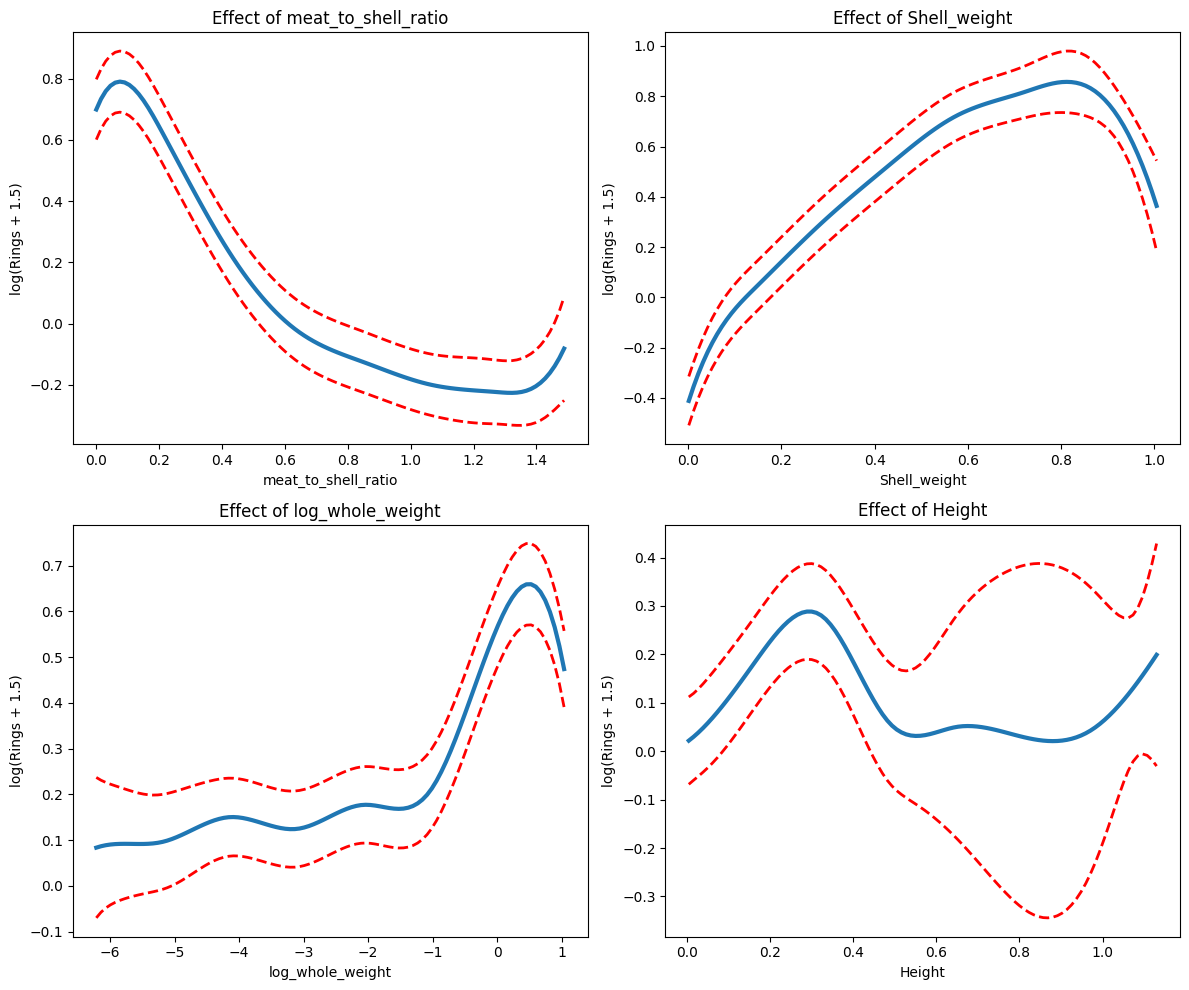

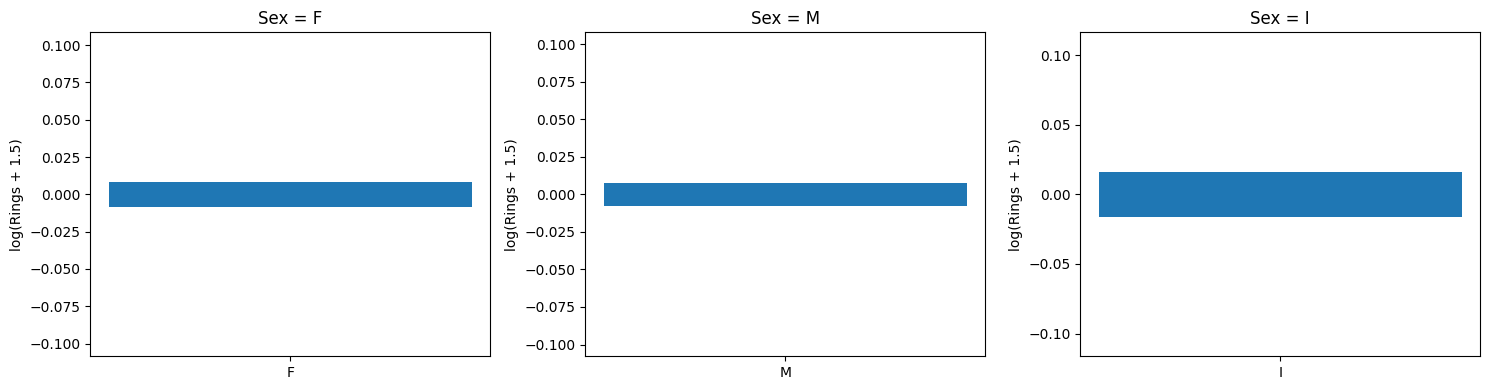

In [48]:
# names for the four smooth terms
num_feats =  ['meat_to_shell_ratio', 'Shell_weight', 'log_whole_weight', 'Height']

# Partial‐dependence plots for the four splines
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()
for i, feat in enumerate(num_feats):
    XX = gam_multi.generate_X_grid(term=i)
    pdp, confi = gam_multi.partial_dependence(term=i, X=XX, width=0.95)
    axes[i].plot(XX[:, i], pdp,     linewidth=3)
    axes[i].plot(XX[:, i], confi[:,0], 'r--', linewidth=2)
    axes[i].plot(XX[:, i], confi[:,1], 'r--', linewidth=2)
    axes[i].set_title(f"Effect of {feat}")
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel("log(Rings + 1.5)")
plt.tight_layout()


# Factor Effects for Sex levels (terms 4,5,6)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for j, level in enumerate(['F','M','I']):
    # generate a grid where only that factor varies
    XX = gam_multi.generate_X_grid(term=4+j)
    pdep = gam_multi.partial_dependence(term=4+j, X=XX)
    axes[j].bar([level], pdep)
    axes[j].set_ylim(min(pdep)-0.1, max(pdep)+0.1)
    axes[j].set_title(f"Sex = {level}")
    axes[j].set_ylabel("log(Rings + 1.5)")
plt.tight_layout()
plt.show()

# 11. Submit results 

In [49]:
# GAM feature lists
num_feats   = ['Shucked_weight', 'Shell_weight', 'log_whole_weight', 'Height']
dummy_feats = ['Sex_F', 'Sex_M', 'Sex_I']

Xg_test = np.column_stack([
    test_encoded[num_feats].values,
    test_encoded[dummy_feats].values
])

# predict 
pred_test_log = gam_multi.predict(Xg_test)
pred_test     = np.exp(pred_test_log) - 1.5

pred_test = np.clip(pred_test, 0, None)
pred_test = np.round(pred_test).astype(int)

# submit
submission = pd.DataFrame({
    'id':    test['id'],
    'Rings': pred_test
})

submission.to_csv('/kaggle/working/submission.csv', index=False)
print("Exported /kaggle/working/submission.csv")

Exported /kaggle/working/submission.csv
